# Выпускной проект: телекоммуникации

# Модель для прогноза оттока клиентов.

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. 

**Цель исследования:**
1. Построить модель для прогноза оттока клиентов.


**Ход исследования**

Данные получим из файлов `contract_new.csv, personal_new.csv, internet_new.csv, phone_new.csv`, 

просмотрим общую информацию о датасетах, оценим качество данных.

Далее приступим к предобработке данных: проверим и исправим ошибки, которые не приведут к искажению конечного результата, оценим их влияние на исследование. 

Затем настанет очередь исследовательского анализа данных и объединение в один датафрейм.

В объединенном датафрейме проведем исследовательский и корреляционный анализ данных.

После этого применим пайплайны для подготовки признаков и обучения модели для каждого региона.

Завершающим этапом исследования будет проверка лучшей модели на тестовых данных.

Таким образом, иследование будет состоять из следующих этапов:

- [Обзор данных](#info)

- [Предобработка данных](#preprocessing)

- [Исследовательский анализ данных](#EDA)

- [Объединение данных](#join)

- [Исследовательский анализ полученного датафрейма](#EDA2)

- [Подготовка данных](#pipeline) 

- [Обучение модели](#model)

- [Тестирование лучшей модели](#test)

- [Итоговые выводы](#final)

## Описание данных

Данные состоят из нескольких файлов, полученных из разных источников.

`contract_new.csv` — информация о договоре.

| | |
| ------ | ------ | 
| **customerID** | идентификатор абонента| 
| **BeginDate** | дата начала действия договора|
| **EndDate** | дата окончания действия договора|
| **Type** | тип оплаты: раз в год-два или ежемесячно|
| **PaperlessBilling** |электронный расчётный лист|
| **PaymentMethod** |тип платежа|
| **MonthlyCharges** |расходы за месяц|
| **TotalCharges** |общие расходы абонента|

`personal_new.csv` - персональные данные клиента.

| | |
| ------ | ------ | 
| **customerID** | идентификатор пользователя| 
| **gender** | пол|
| **SeniorCitizen** | является ли абонент пенсионером|
| **Partner** |есть ли у абонента супруг или супруга|
| **Dependents** |есть ли у абонента дети|

`internet_new.csv` - информация об интернет-услугах.

| | |
| ------ | ------ | 
| **customerID** | идентификатор пользователя| 
| **InternetService** | тип подключения|
| **OnlineSecurity** |блокировка опасных сайтов|
| **OnlineBackup** |облачное хранилище файлов для резервного копирования данных|
| **DeviceProtection** |антивирус|
| **TechSupport** |выделенная линия технической поддержки|
| **StreamingTV** |стриминговое телевидение|
| **StreamingMovies** |каталог фильмов|

`phone_new.csv` - информация об услугах телефонии.

| | |
| ------ | ------ | 
| **customerID** | идентификатор пользователя| 
| **MultipleLines** | подключение телефона к нескольким линиям одновременно|

Информация о договорах актуальна на 1 февраля 2020 года.

## **Обзор данных**
<a id='info'></a>

In [1]:
# Игнорируем предупреждения
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [61]:
# Импротируем необходимые библиотеки
import os
import importlib.metadata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from scipy import stats as st
sns.set()

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, RocCurveDisplay, accuracy_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif


# Зафиксируем случайность  и размер тестовой выборки
RANDOM_STATE = 171125
TEST_SIZE = 0.25

sklearn.__version__

'1.8.0'

In [3]:
# Функция для чтения файлов
def read_file(file):
    pth1 = f'/datasets/{file}'
    pth2 = file
    
    if os.path.exists(pth1):
        return pd.read_csv(pth1)
    elif os.path.exists(pth2):
        return pd.read_csv(pth2)
    else:
        print('Something is wrong')

In [4]:
# Загружаем файлы
contract = read_file('contract_new.csv')
personal = read_file('personal_new.csv')
internet = read_file('internet_new.csv')
phone = read_file('phone_new.csv')

In [5]:
# Создаем функцию для получения общей информации
def general_info(df):
    return df.info(), display(df.shape, df.head())

In [6]:
# Посмотрим на первые 5 строк каждого датасета и общую информацию
general_info(contract)
general_info(personal)
general_info(internet)
general_info(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


(7043, 8)

customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


(7043, 5)

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


(5517, 8)

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


(6361, 2)

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

(None, None)

**Вывод:** 

Датафрейм `contract_new.csv` содержит **7043 строк и 8 столбцов**. В данных пропуски отсутствуют, типы данных некорректны.

Датафрейм `personal_new.csv` содержит **7043 строк и 5 столбцов**. В данных пропуски отсутствуют, типы данных корректны.

Датафрейм `internet_new.csv` содержит **5517 строк и 8 столбцов**. В данных пропуски отсутствуют, типы данных корректны.

Датафрейм `phone_new.csv` содержит **6361 строку и 2 столбца**. В данных пропуски отсутствуют, типы данных корректны.

## **Предобработка данных**
<a id='preprocessing'></a>

### **Явные и неявные дубликаты**

Проверим количество **явных** дубликатов в данных.

In [7]:
display(contract.duplicated().sum(),
        personal.duplicated().sum(),
        internet.duplicated().sum(),
        phone.duplicated().sum())

0

0

0

0

**Явные** дубликаты не обнаружены.

Проверим количество **неявных** дубликатов в данных.

In [8]:
# Напишем функцию для уникальных значений категориальных столбцов
def cat_unique(df):
    columns = df.select_dtypes(exclude='number').columns.to_list()
    for col in columns:
         display(col, df[col].unique())

In [9]:
# Выведем уникальные значения категориальных столбцов 
cat_unique(contract)
cat_unique(personal)
cat_unique(internet)
cat_unique(phone)

'customerID'

array(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', ..., '4801-JZAZL',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

'BeginDate'

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

'EndDate'

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

'Type'

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

'PaperlessBilling'

array(['Yes', 'No'], dtype=object)

'PaymentMethod'

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

'TotalCharges'

array(['31.04', '2071.84', '226.17', ..., '325.6', '520.8', '7251.82'],
      dtype=object)

'customerID'

array(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', ..., '4801-JZAZL',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

'gender'

array(['Female', 'Male'], dtype=object)

'Partner'

array(['Yes', 'No'], dtype=object)

'Dependents'

array(['No', 'Yes'], dtype=object)

'customerID'

array(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', ..., '4801-JZAZL',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

'InternetService'

array(['DSL', 'Fiber optic'], dtype=object)

'OnlineSecurity'

array(['No', 'Yes'], dtype=object)

'OnlineBackup'

array(['Yes', 'No'], dtype=object)

'DeviceProtection'

array(['No', 'Yes'], dtype=object)

'TechSupport'

array(['No', 'Yes'], dtype=object)

'StreamingTV'

array(['No', 'Yes'], dtype=object)

'StreamingMovies'

array(['No', 'Yes'], dtype=object)

'customerID'

array(['5575-GNVDE', '3668-QPYBK', '9237-HQITU', ..., '2234-XADUH',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

'MultipleLines'

array(['No', 'Yes'], dtype=object)

**Неявные** дубликаты не обнаружены.

### Преобразование типов данных

Преобразуем тип данных `object` в числовой в столбце `TotalCharges` датафрейма contract.

In [10]:
# Преобразуем тип данных в числовой
test_values = list(contract['TotalCharges'].unique())
try:
    result = pd.to_numeric(test_values)
    print("Тестовые значения преобразуются нормально")
except Exception as e:
    print(f"Ошибка: {e}")

Ошибка: Unable to parse string " " at position 485


Мы видим, что в столбце присутствуют значения " ". Посмотрим на них в датафрейме.

In [11]:
contract[contract['TotalCharges'] == ' ']

customerID   BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI  2020-02-01      No  Two year              Yes   
753   3115-CZMZD  2020-02-01      No  Two year               No   
936   5709-LVOEQ  2020-02-01      No  Two year               No   
1082  4367-NUYAO  2020-02-01      No  Two year               No   
1340  1371-DWPAZ  2020-02-01      No  Two year               No   
3331  7644-OMVMY  2020-02-01      No  Two year               No   
3826  3213-VVOLG  2020-02-01      No  Two year               No   
4380  2520-SGTTA  2020-02-01      No  Two year               No   
5218  2923-ARZLG  2020-02-01      No  One year              Yes   
6670  4075-WKNIU  2020-02-01      No  Two year               No   
6754  2775-SEFEE  2020-02-01      No  Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  
488   Bank transfer (automatic)           52.55               
753                Mailed check           20.25               
936                Mailed check           80.85               
1082               Mailed check           25.75               
1340    Credit card (automatic)           56.05               
3331               Mailed check           19.85               
3826               Mailed check           25.35               
4380               Mailed check           20.00               
5218               Mailed check           19.70               
6670               Mailed check           73.35               
6754  Bank transfer (automatic)           61.90

Все записи, соответствующие значению " " в столбце `TotalCharges` являются записью в последнем месяце актуальной даты в таблице. Можно утверждать, что покупатели, у которых обслуживание началось только в феврале 2020 года, в целом оплатили только один месяц. Значит, их общие расходы соответствуют тратам за февраль.

In [12]:
# Заполним пустые значения в столбце TotalCharges
mask = contract['TotalCharges'] == ' '
contract.loc[mask, 'TotalCharges'] = contract.loc[mask, 'MonthlyCharges']

In [13]:
# Преобразуем тип данных в столбце в численный
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

Преобразуем тип данных `object` в тип `datetime` в столбце `BeginDate`, `EndDate` датафрейма contract.

In [14]:
# Приводим столбец BeginDate к типу datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

Со столбцом `EndDate` ситуация другая - в нем присутствует значение `No`, что означает, договор клиента не разорван и он продолжает пользоваться услугами. Поэтому выделим этот признак в отдельный столбец (он будет у нас целевым) и преобразуем значения в столбце EndDate.

In [15]:
# Создаем столбец с активными клиентами и преобразуем тип данных в столбце EndDate
contract['IsActive'] = (contract['EndDate'] == 'No').astype(int)
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d', errors='coerce')

Преобразуем числовой тип в признаке `SeniorCitizen` в тип `object`.

In [16]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

### Добавление новых признаков

Создадим новые признаки на основе имеющихся для дальнейших исследований.

Посчитаем, сколько дней длится договор у клиента.

In [17]:
# Создаем столбец с количеством дней договора
reference_date = pd.to_datetime('2020-02-01')
contract['Duration'] = (contract['EndDate'].fillna(reference_date) - contract['BeginDate']).dt.days

In [18]:
# Проверка
personal.info(), contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   Monthly

(None, None)

Здесь мы видим, что преобразование типов данных произошло успешно, в столбце 'EndDate' теперь присутствуют пропущенные значения (это клиенты, у которых все еще действует договор) и мы добавили новый столбец с количеством дней договора.

**Вывод:** таким образом, мы провели предобработку данных, убедились в отсутствии явных и неявных дубликатов, добавили новый признак, а также изменили типы данных в датафрейме contract и personal.

## **Исследовательский анализ данных**
<a id='EDA'></a>

### **Статистический анализ количественных признаков**

В наших данных только датафрейм contract имеет количественные признаки. Исследуем их.

In [19]:
# Выведем статистики количественных признаков
contract.describe()

BeginDate                        EndDate  \
count                           7043                           1101   
mean   2017-04-30 13:01:50.918642688  2018-03-12 18:21:15.204359680   
min              2013-10-01 00:00:00            2014-06-01 00:00:00   
25%              2015-06-01 00:00:00            2017-05-01 00:00:00   
50%              2017-09-01 00:00:00            2018-06-01 00:00:00   
75%              2019-04-01 00:00:00            2019-04-01 00:00:00   
max              2020-02-01 00:00:00            2020-01-01 00:00:00   
std                              NaN                            NaN   

       MonthlyCharges  TotalCharges     IsActive     Duration  
count     7043.000000   7043.000000  7043.000000  7043.000000  
mean        64.761692   2115.377573     0.843675   898.555729  
min         18.250000     19.050000     0.000000     0.000000  
25%         35.500000    436.750000     1.000000   276.000000  
50%         70.350000   1343.350000     1.000000   761.000000  
75%         89.850000   3236.690000     1.000000  1461.000000  
max        118.750000   9221.380000     1.000000  2314.000000  
std         30.090047   2112.678861     0.363189   683.130510

Во всех признаках минимальные и максимальные значения не имеют аномалий. 

В признаке `MonthlyCharges` среднее чуть смещено вправо относительно медианы, значит в данных есть небольшие выбросы сверху.

В признаке `TotalCharges` среднее почти в два раза больше медианы, значит распределение смещено вправо, в данных много выбросов сверху.

В признаке `Duration` среднее также больше медианы, что говорит о наличии выбросов.

Построим графики для количественных признаков: гистограмму частотности распределения и ящик с усами.

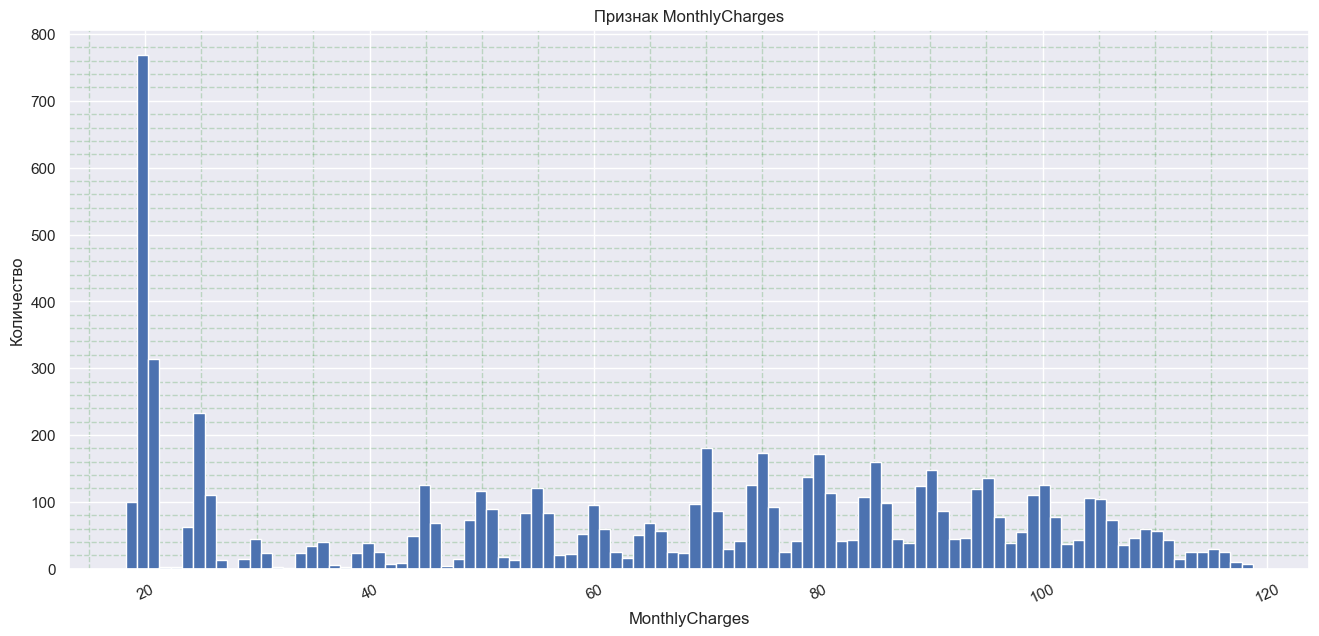

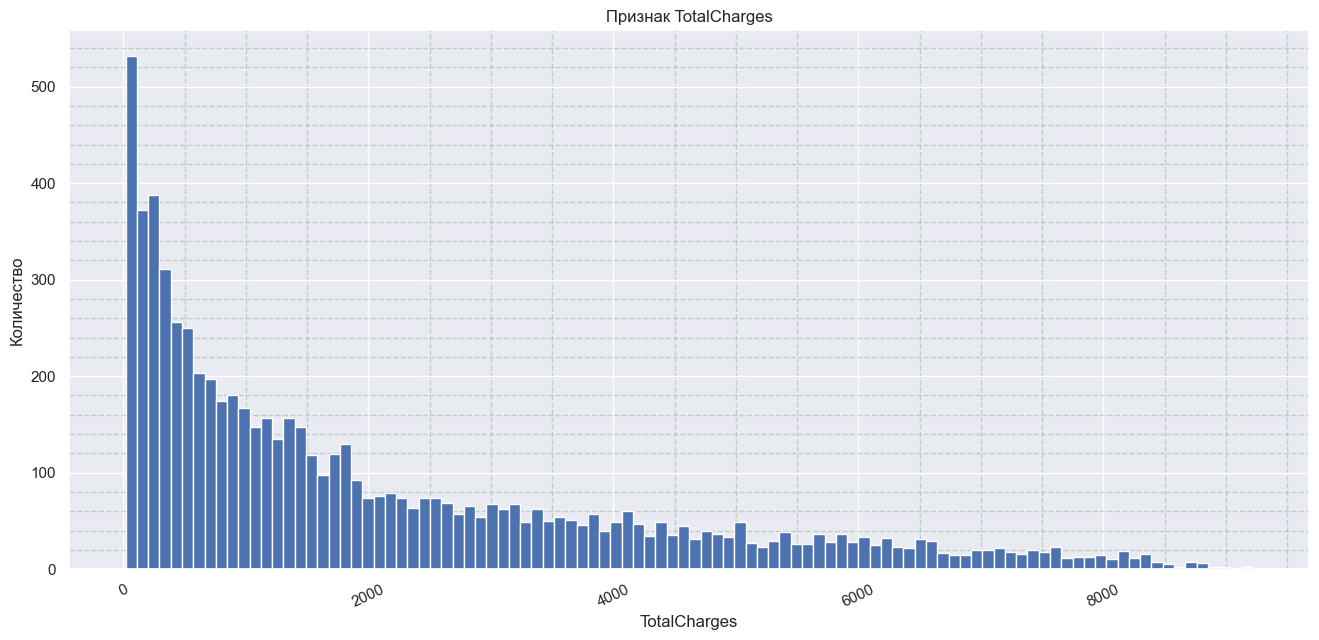

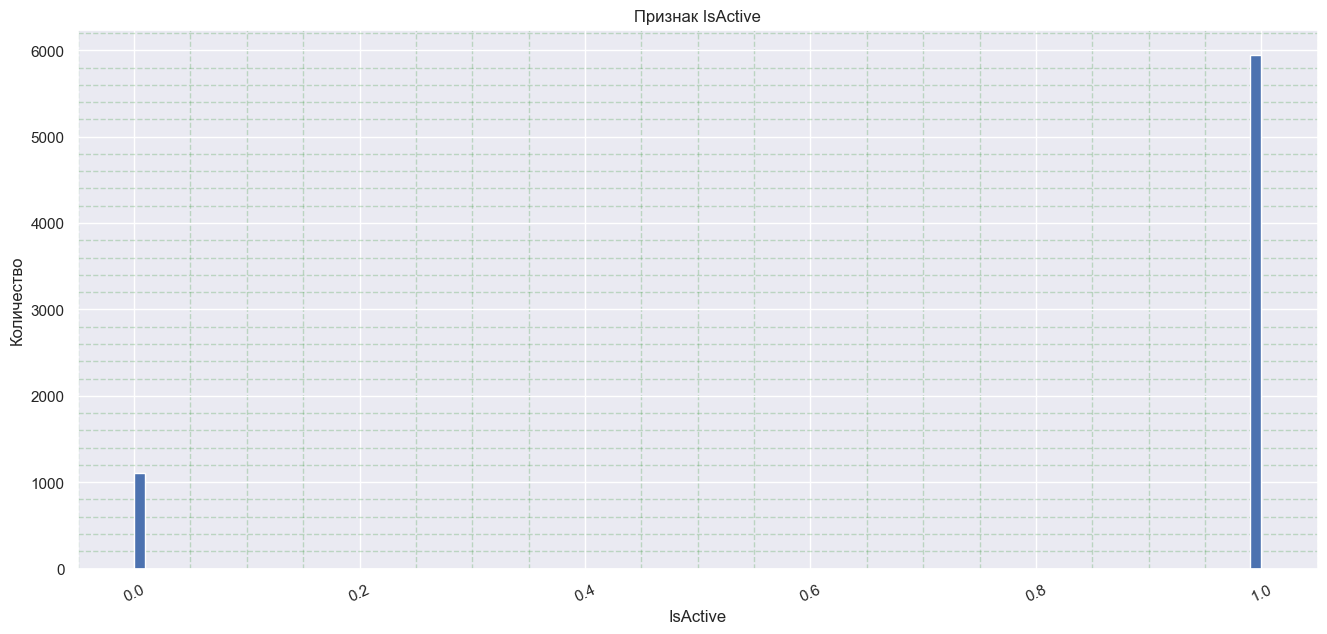

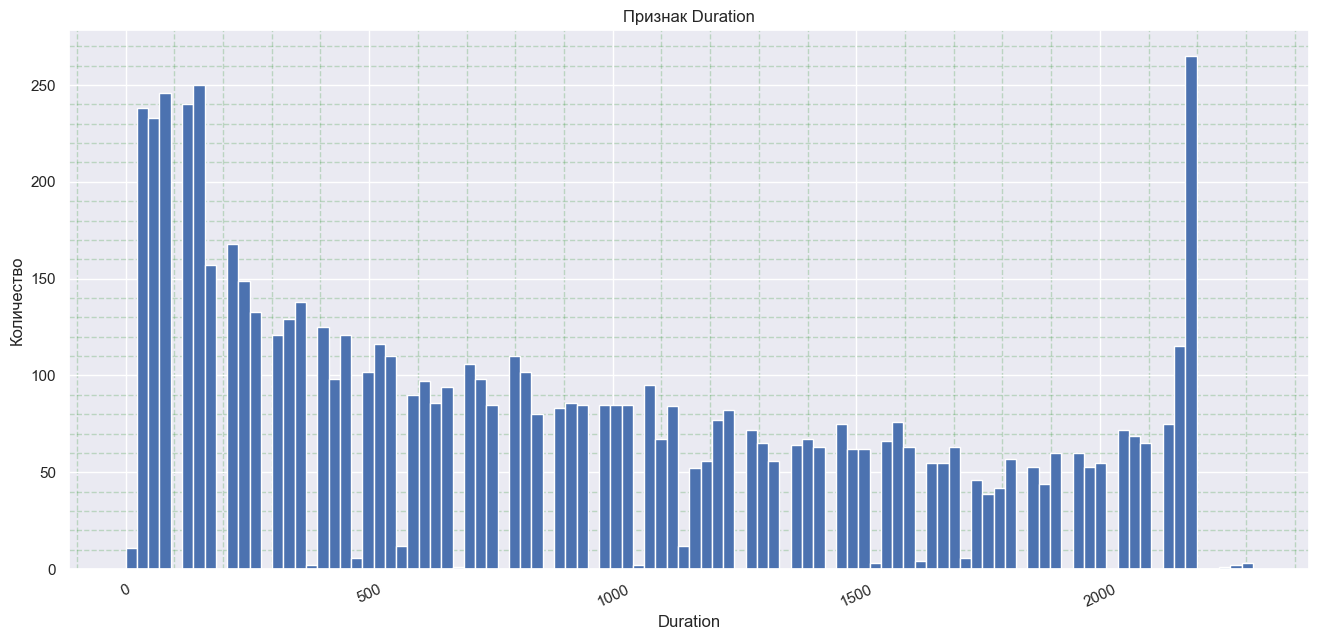

In [20]:
# Строим гистограмму
for col in contract.select_dtypes(include='number').columns:
        plt.figure(figsize=(16,7))
        contract[col].hist(bins=100)
        plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
        plt.minorticks_on()
        plt.tick_params(which='minor')
        plt.xticks(rotation = 25)
        plt.title(f'Признак {col}')
        plt.xlabel(col)
        plt.ylabel('Количество')
        plt.show()

Мы видим, что признаки не имеют аномалий, а вид их распределений возможно связан с особенностями данных. Также в целевом признаке мы наблюдаем дисбаланс классов, но так как ключевая метрика - ROC-AUC, то мы не будем исправлять и балансировать их, потому что эта метрика устойчива к дисбалансу.

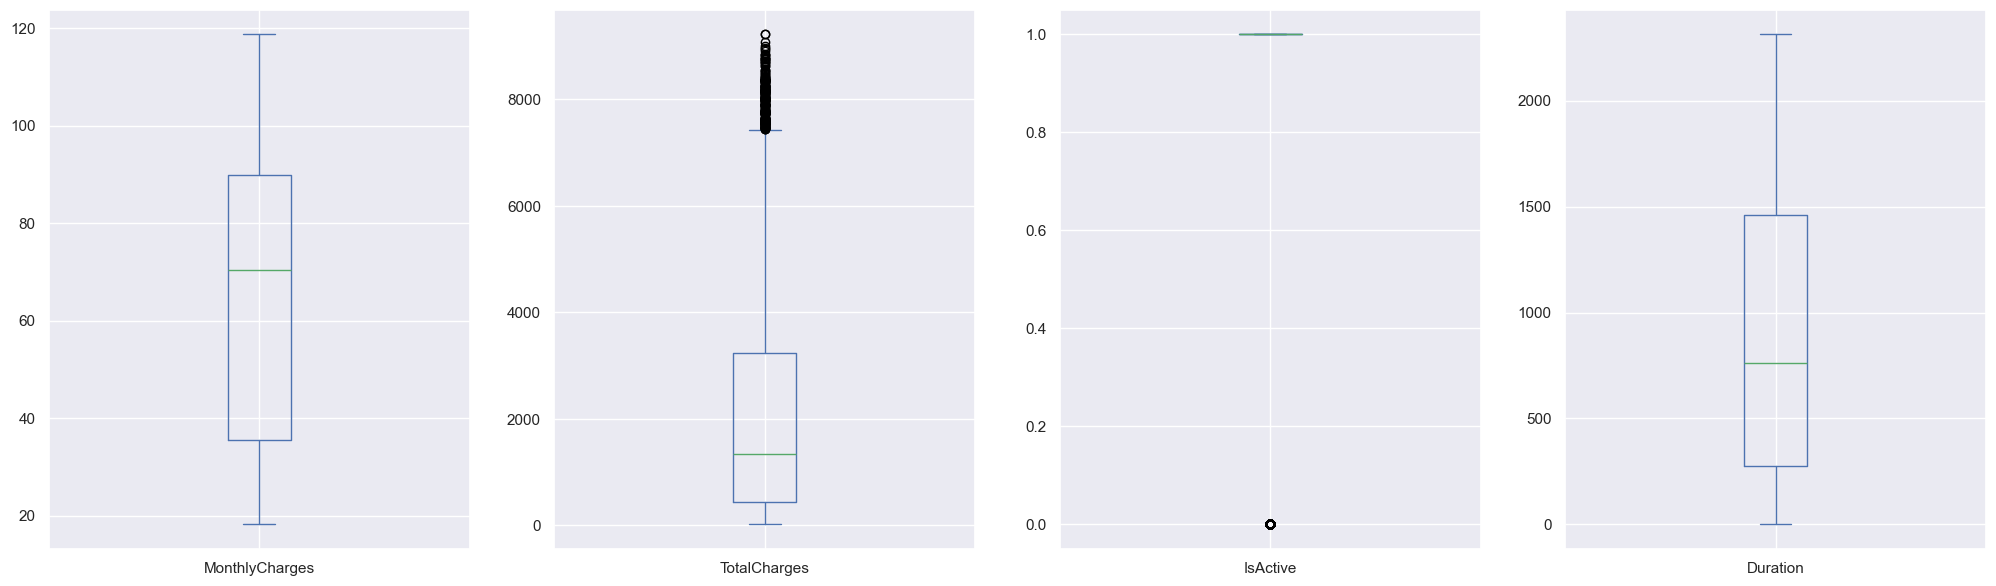

In [21]:
# Строим ящик с усами
contract.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(25, 7)
);

Признак `TotalCharges` имеет много выбросов сверху, это может быть связано со спецификой параметра.

### **Статистический анализ категориальных признаков**

Посмотрим на распределения категориальных признаков во всех датафреймах.

In [22]:
# Создаем функцию, которая строит столбчатую диаграмму для каждого категориального столбца 
def cat_plot(df):
    for col in df.drop(['customerID'], axis=1).select_dtypes(include=['object']).columns:
        plt.figure(figsize=(16,7))
        ax = sns.countplot(x=col, data=df, palette='viridis')
        # Добавляем подписи с процентами
        total = len(df)
        for p in ax.patches:
            percentage = 100 * p.get_height() / total
            ax.text(p.get_x() + p.get_width()/2, p.get_height() + 5, 
                   f'{percentage:.1f}%', ha='center', fontsize=10)
        plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
        plt.minorticks_on()
        plt.tick_params(which='minor')
        plt.xticks(rotation = 25)
        plt.title(f'Признак {col}')
        plt.xlabel(col)
        plt.ylabel('Количество')
        plt.show()

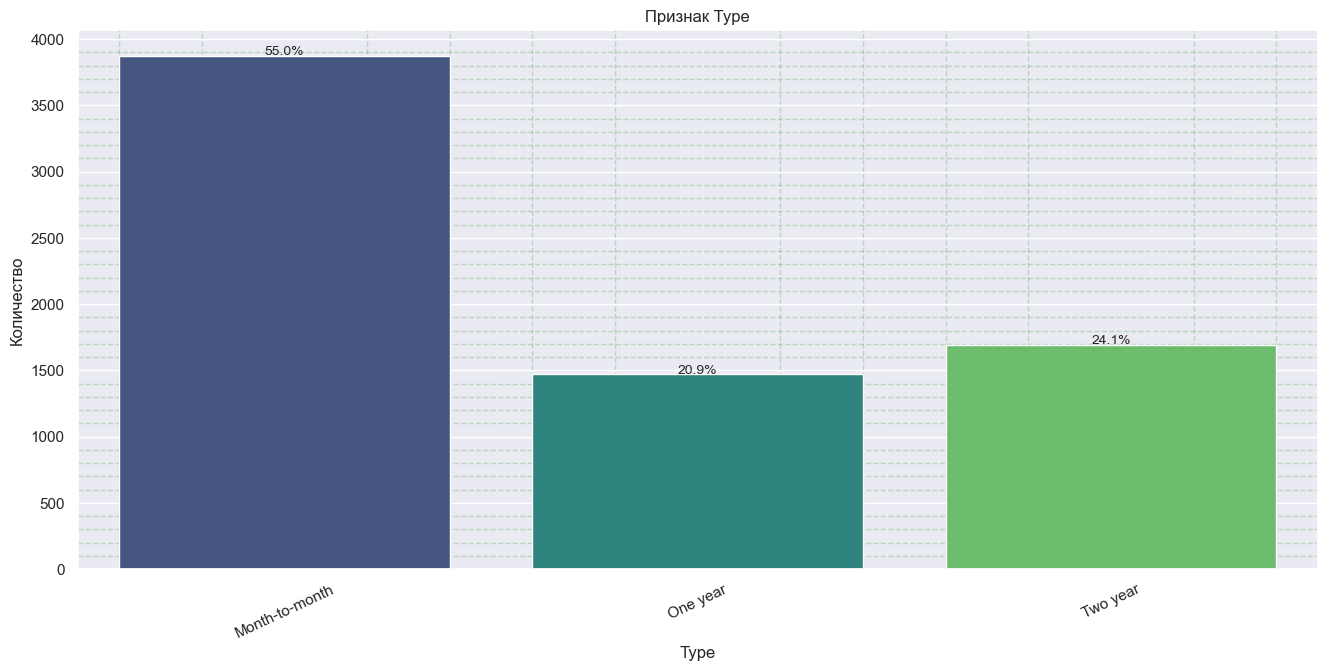

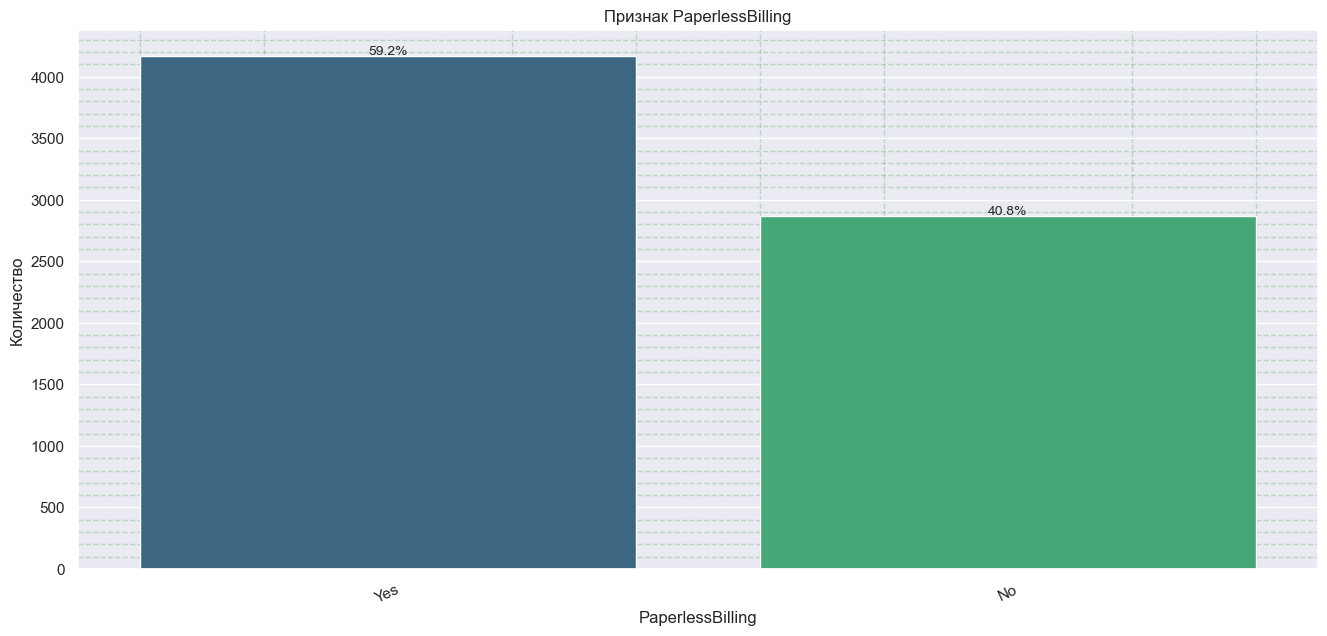

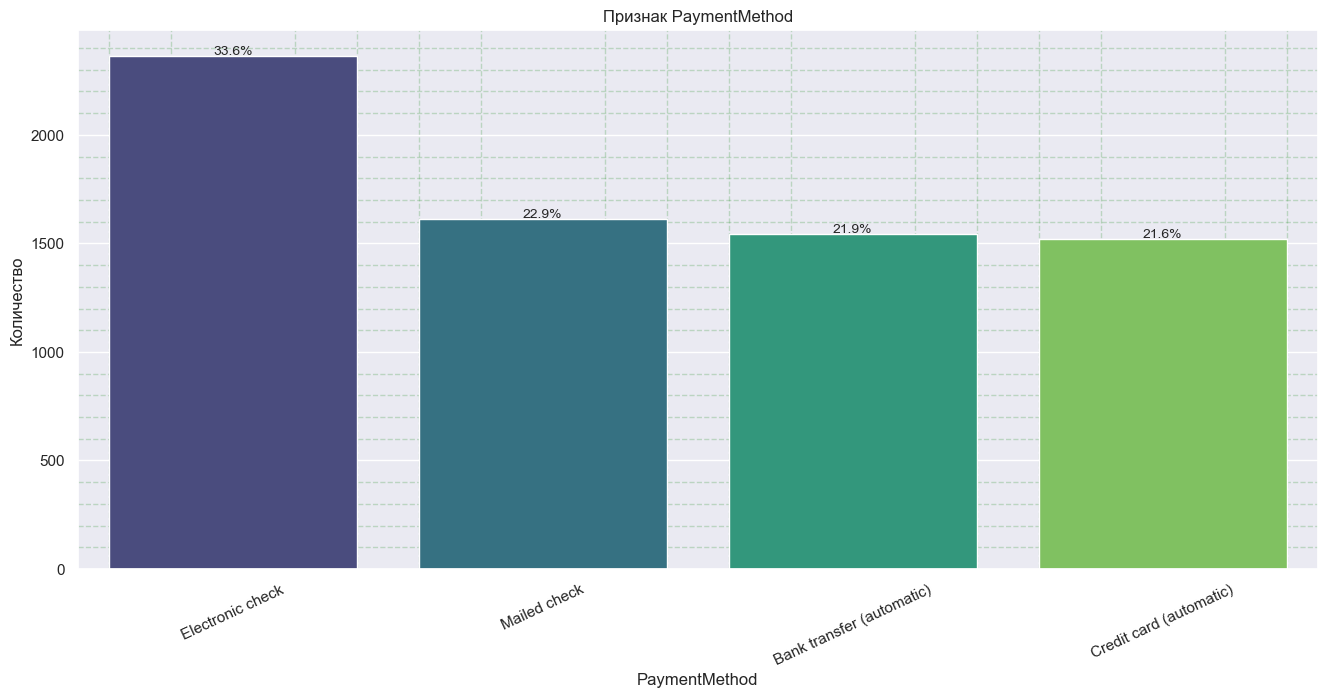

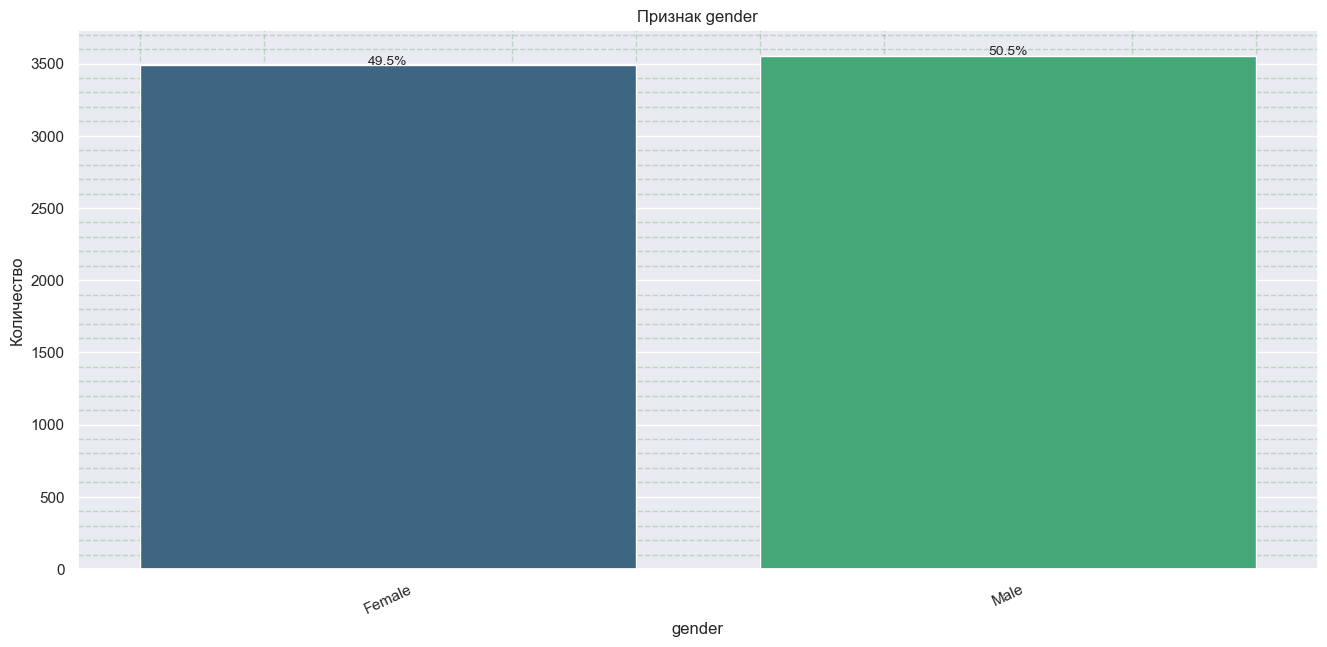

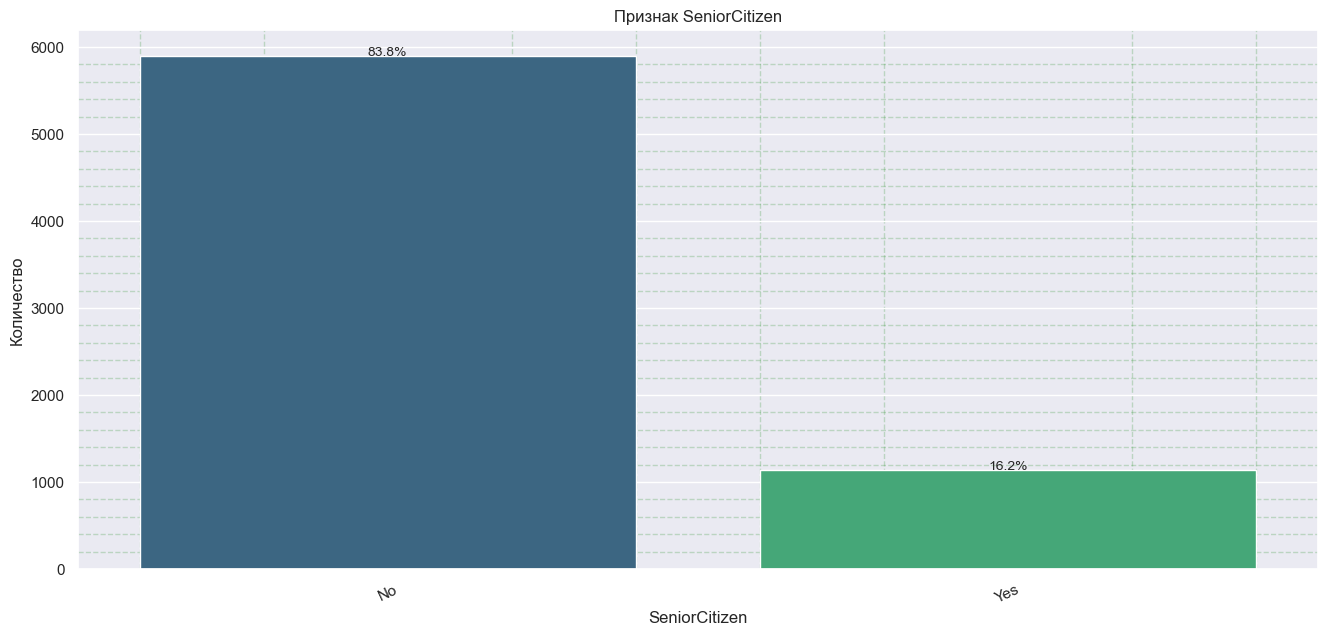

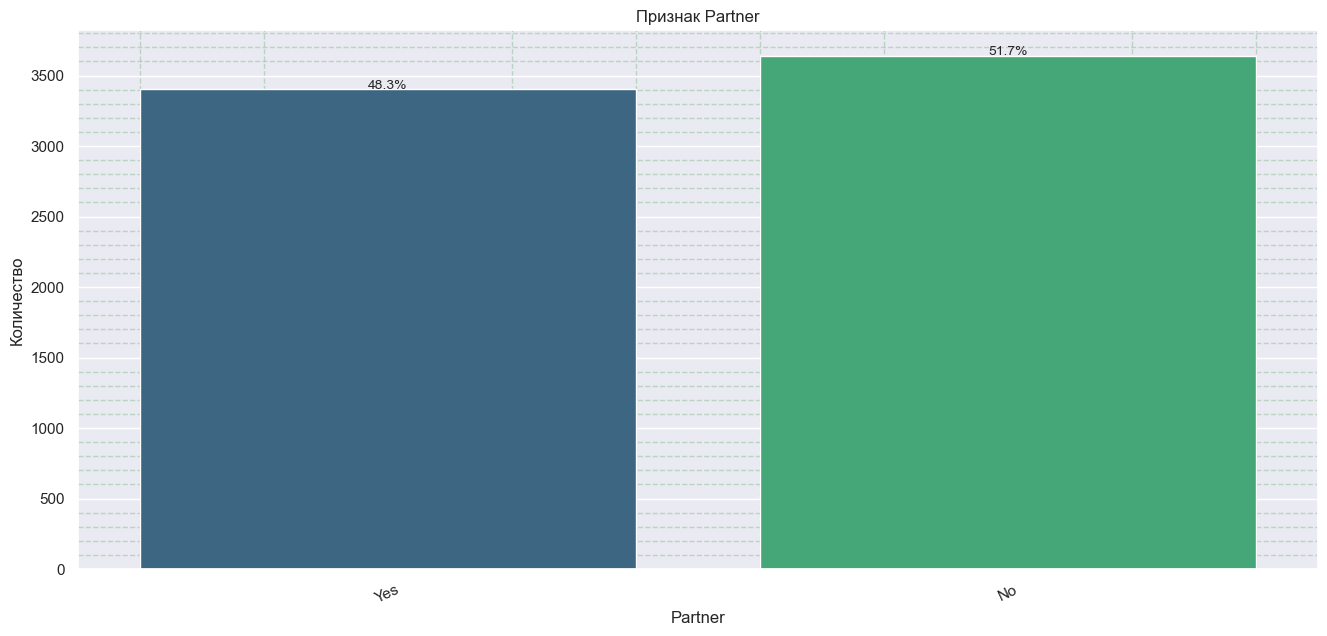

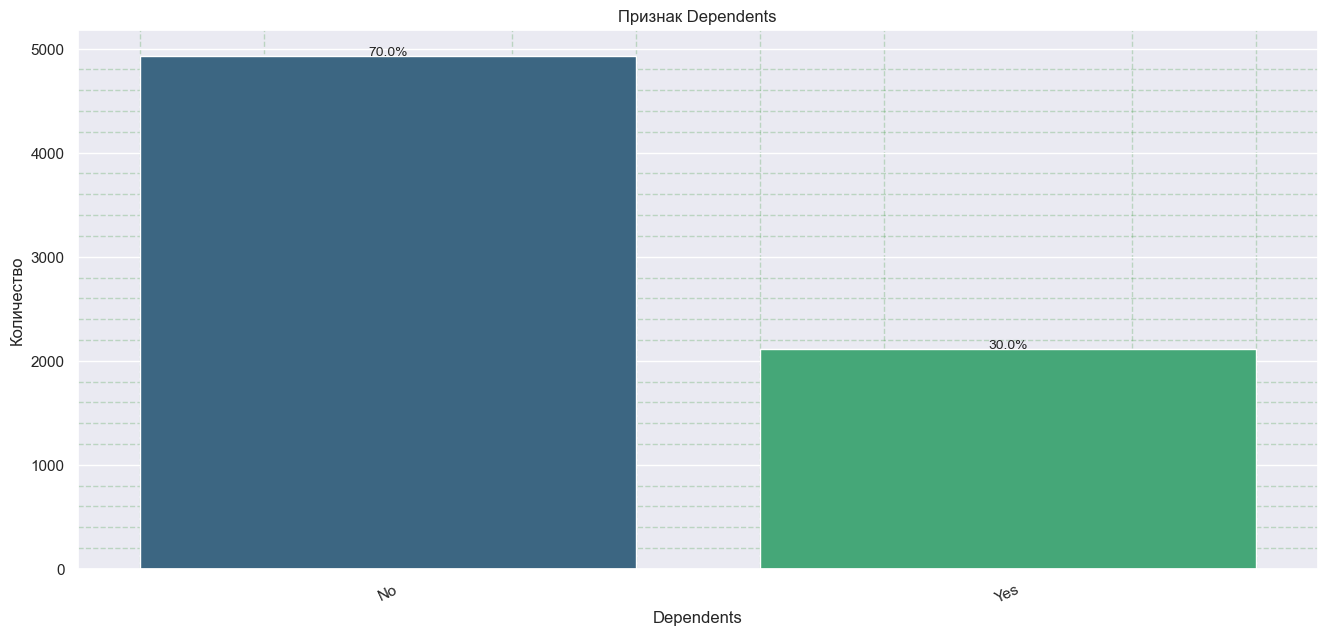

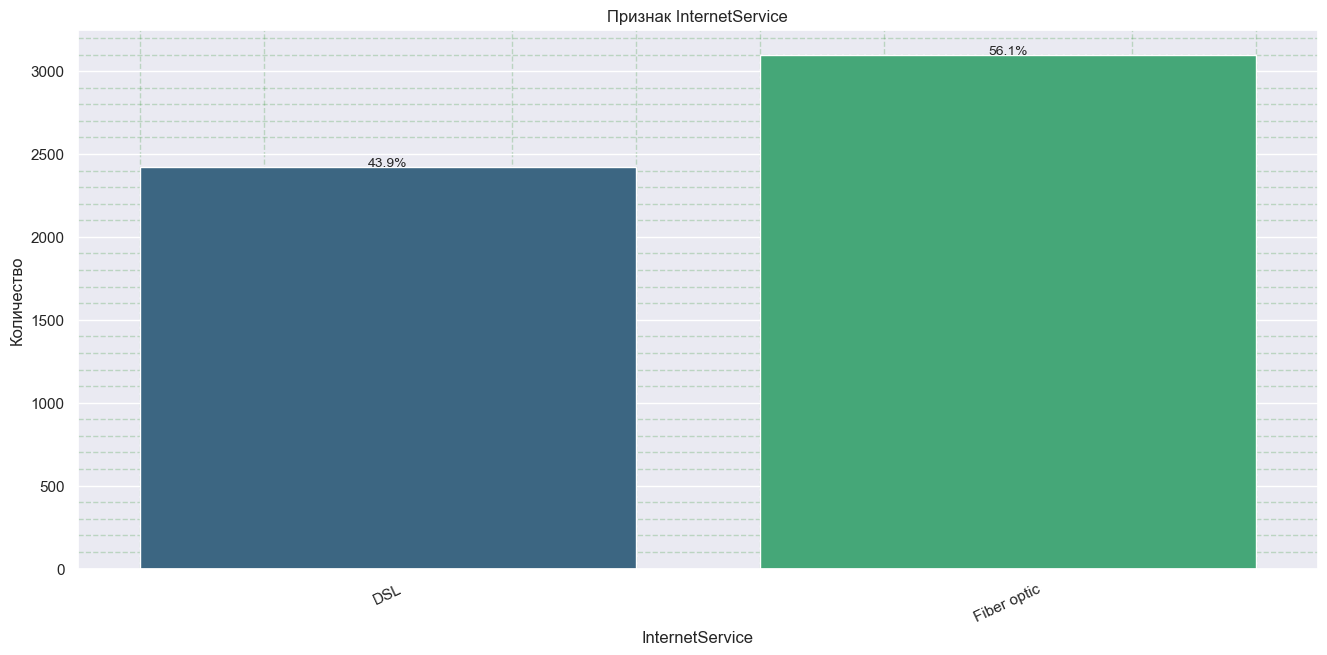

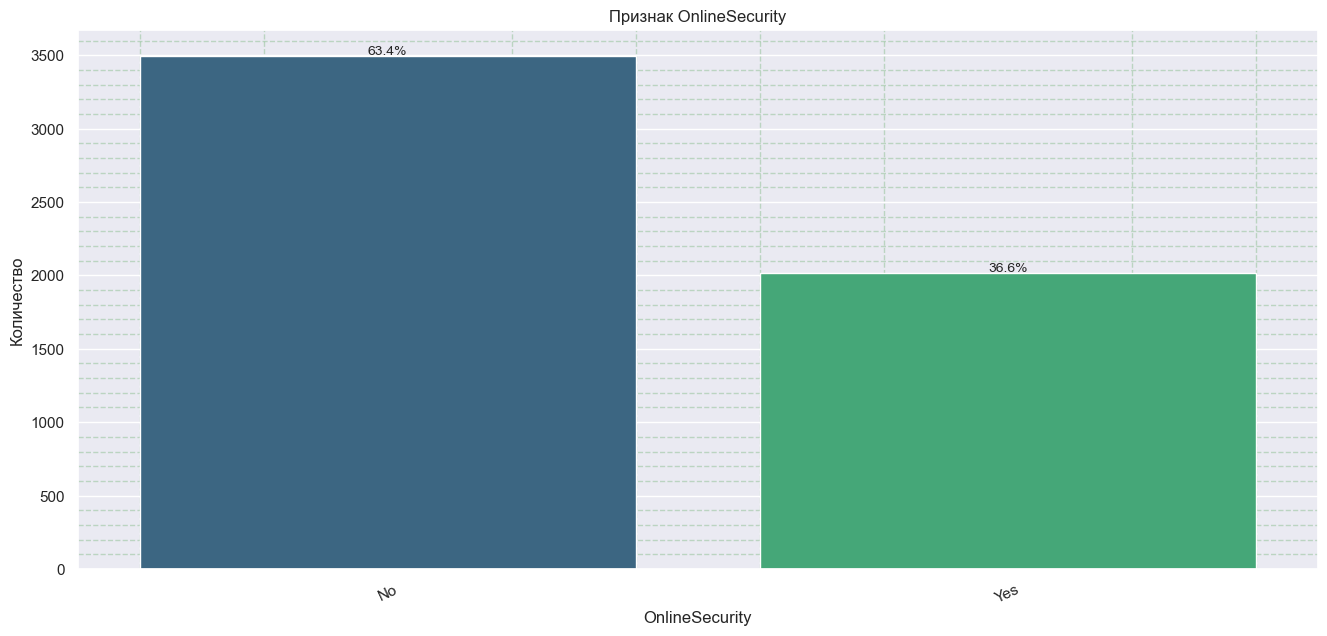

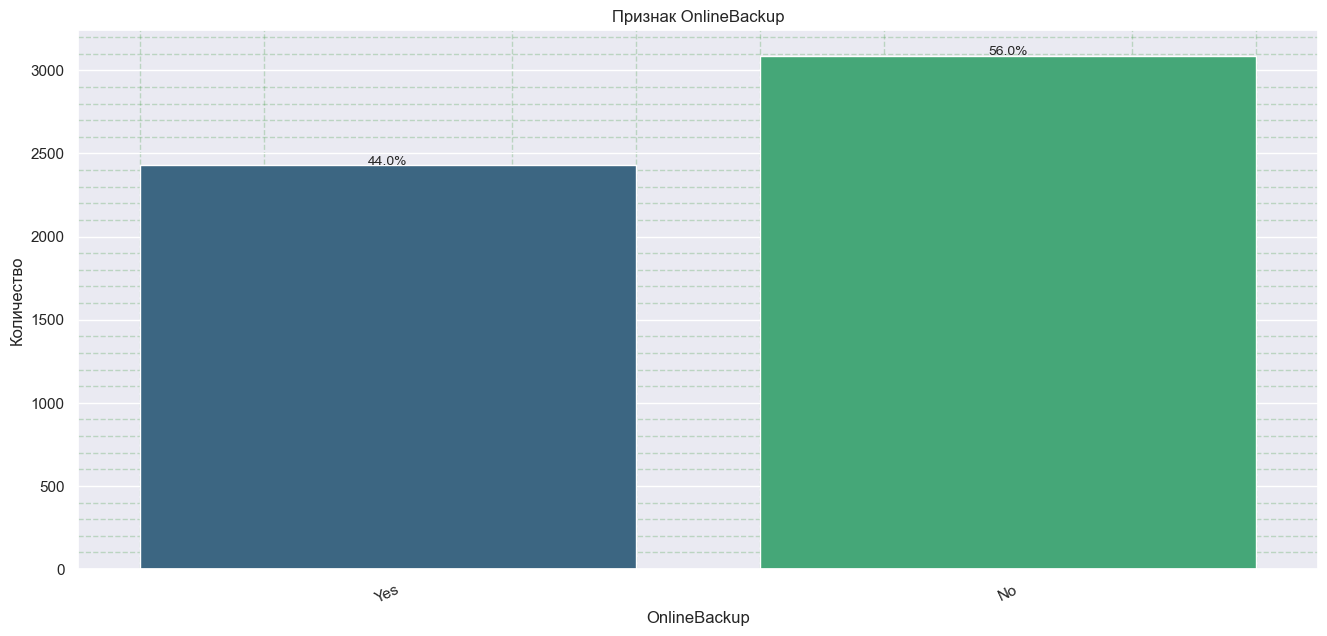

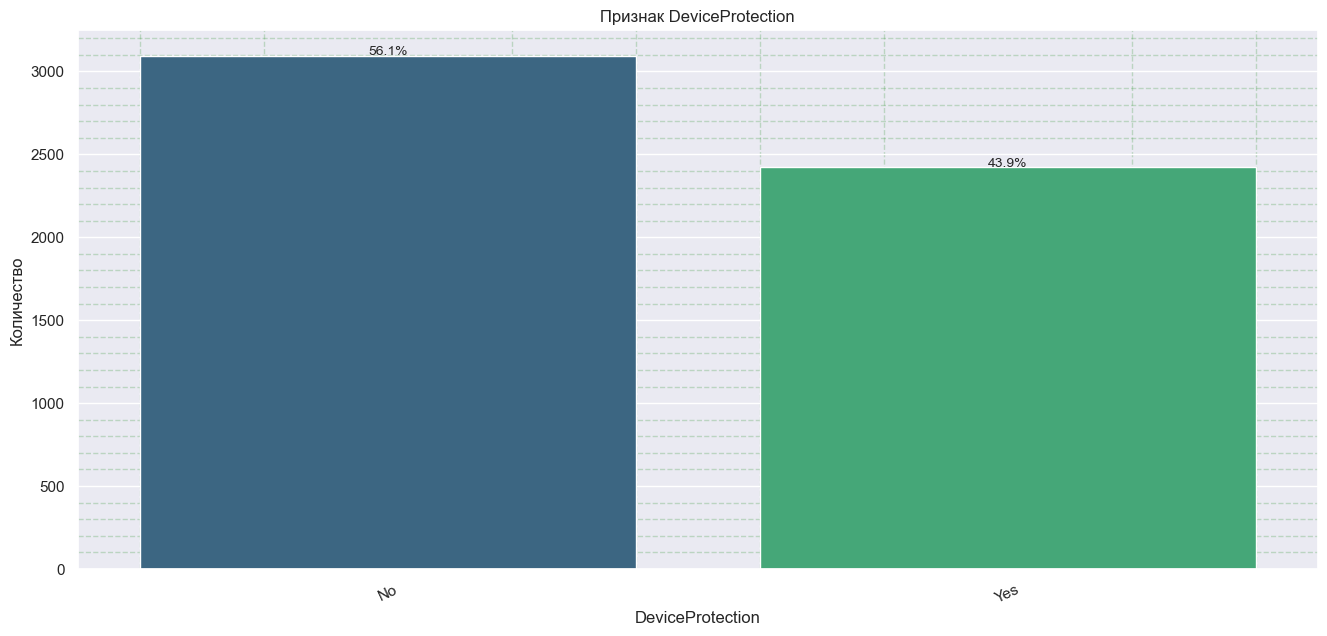

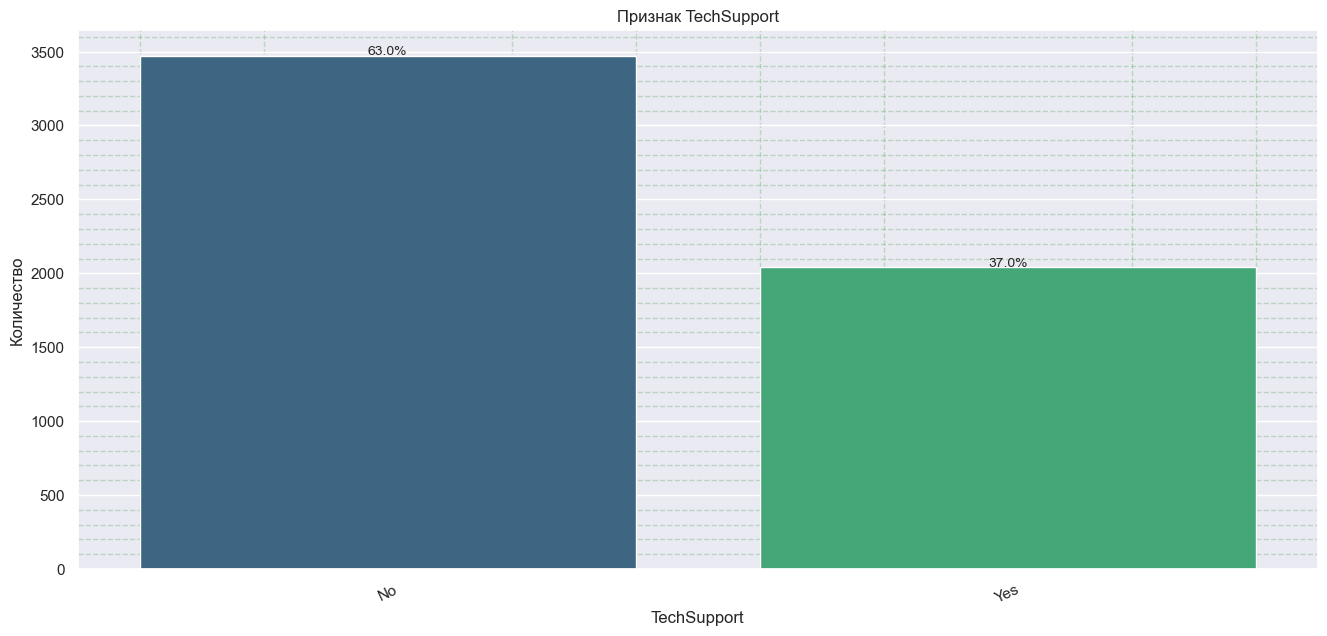

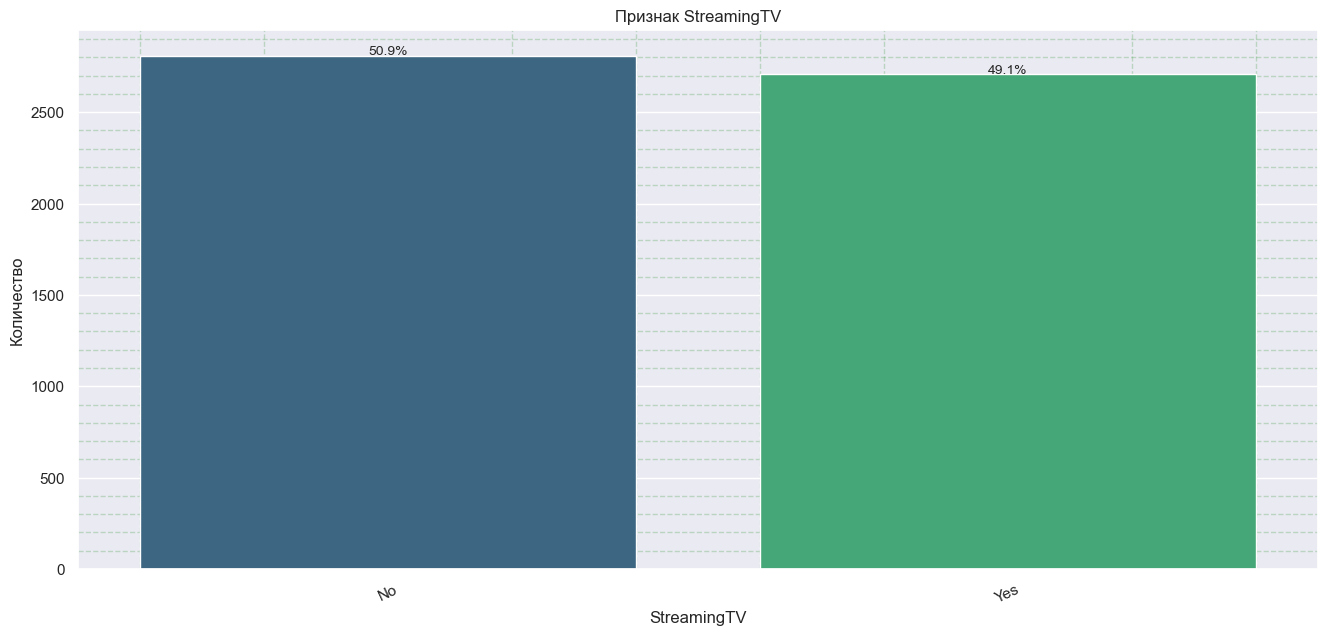

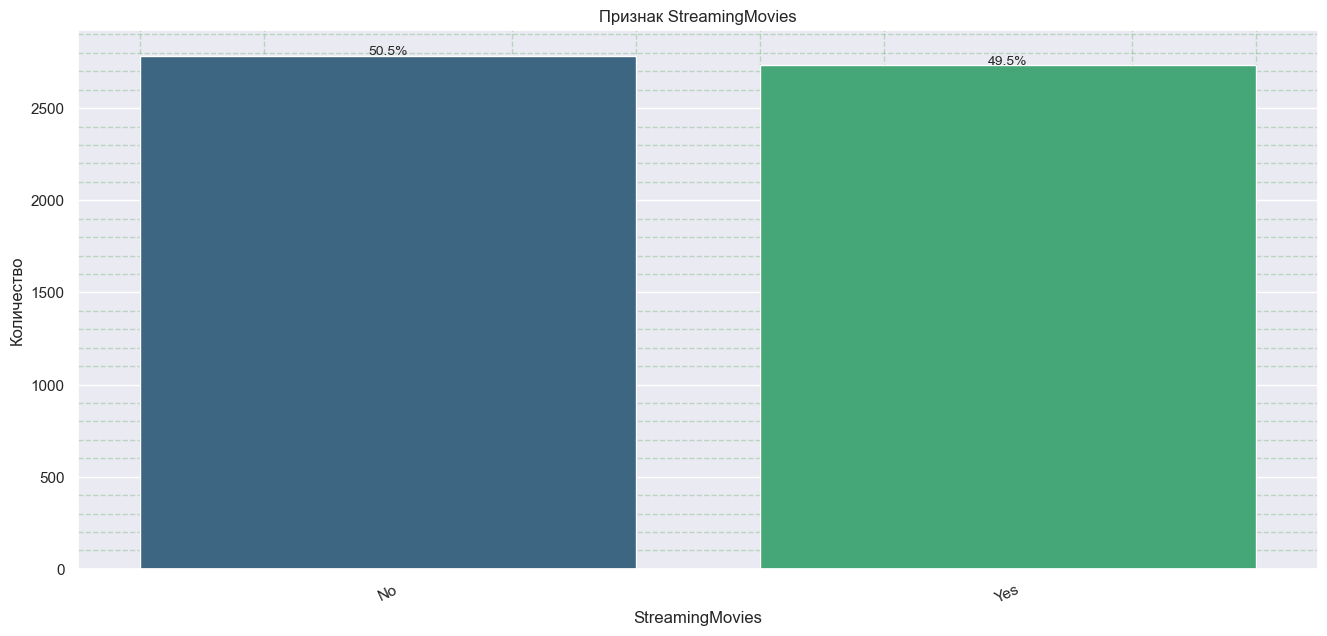

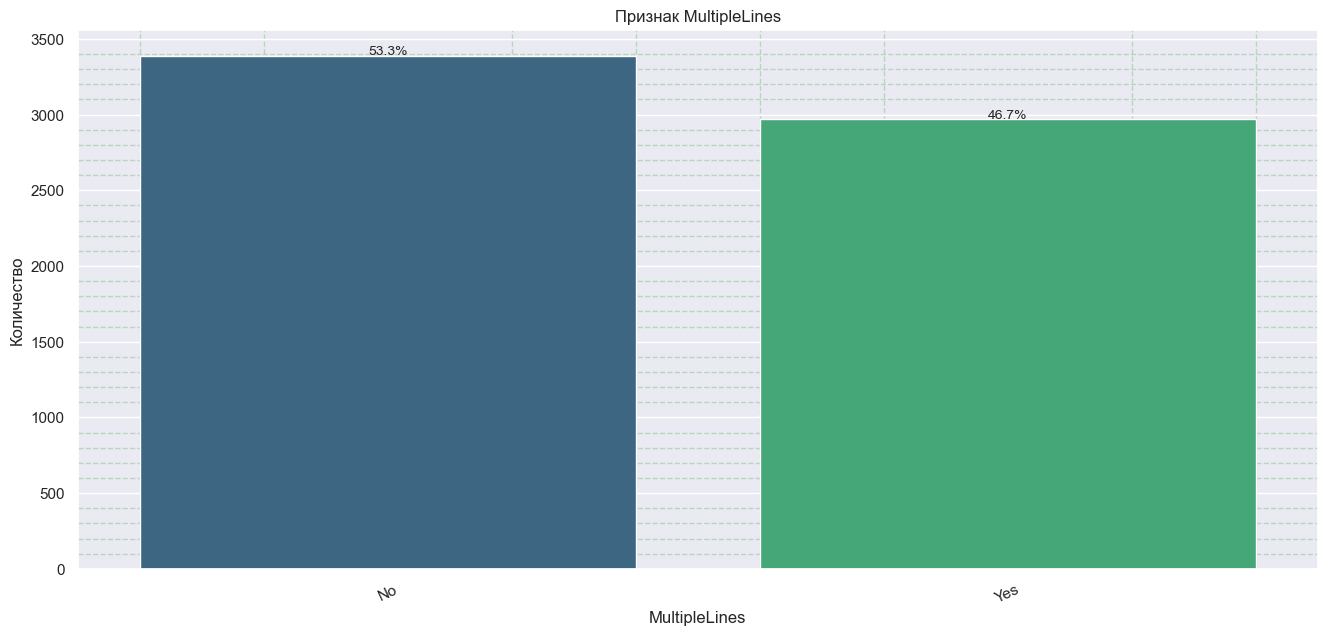

In [23]:
# Строим графики
cat_plot(contract)
cat_plot(personal)
cat_plot(internet)
cat_plot(phone)

Мы видим, что

- больше всего подписок оплачено ежемесячно;

- электронным расчетным листом чаще пользуются;

- все способы оплаты пользуются примерно одинаковым спросом, однако электронным чеком пользуются немного чаще;

- среди клиентов мужчины и женщины встречаются одинаково часто;

- пожилых клиентов в 5 раз меньше;

- женатых и неженатых примерно одинаковое количество среди покупателей;

- клиентов без детей в 2,3 раза больше, чем с ними;

- интернет через оптоволоконный кабель подключают немного чаще, чем через телефонную линию;

- услуги, которыми клиенты в основном не пользуются: блокировка небезопасных сайтов, облачное хранилище файлов для резервного копирования данных, антивирус, выделенная линия технической поддержки.

**Вывод:** таким образом, мы провели исследовательский анализ численных и категориальных признаков и оценили их распределение.

## **Объединение данных**
<a id='join'></a>

Создадим один датафрейм, в котором объединим все имеющиеся данные.

In [24]:
# Добавим признак имя_папы из файла ferma_dad.csv, соединив его с остальными данными ferma_main.csv по ключу.
df_merged = contract.merge(personal, on='customerID', how='left')\
            .merge(internet, on='customerID', how='left')\
            .merge(phone, on='customerID', how='left')
# Проверка сохранения данных
print(df_merged.shape, contract.shape)

(7043, 22) (7043, 10)


Выведем информацию о полученном датафрейме на экран.

In [25]:
display(df_merged.info(), df_merged.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   IsActive          7043 non-null   int64         
 9   Duration          7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   object        
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 n

None

customerID  BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01     NaT  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01     NaT        One year               No   
2  3668-QPYBK 2019-10-01     NaT  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01     NaT        One year               No   
4  9237-HQITU 2019-09-01     NaT  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  IsActive  \
0           Electronic check           29.85         31.04         1   
1               Mailed check           56.95       2071.84         1   
2               Mailed check           53.85        226.17         1   
3  Bank transfer (automatic)           42.30       1960.60         1   
4           Electronic check           70.70        353.50         1   

   Duration  ... Partner Dependents InternetService OnlineSecurity  \
0        31  ...     Yes         No             DSL             No   
1      1036  ...      No         No             DSL            Yes   
2       123  ...      No         No             DSL            Yes   
3      1371  ...      No         No             DSL            Yes   
4       153  ...      No         No     Fiber optic             No   

  OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
0          Yes               No          No          No              No   
1           No              Yes          No          No              No   
2          Yes               No          No          No              No   
3           No              Yes         Yes          No              No   
4           No               No          No          No              No   

  MultipleLines  
0           NaN  
1            No  
2            No  
3           NaN  
4            No  

[5 rows x 22 columns]

В результате в объединенном датасете оказались пропуски, что связано с клиентами, которые могут пользоваться не всеми услугами компании. Заполним их в пайплайне при подготовке данных.

### Создание нового столбца

Создадим вспомогательный столбец с количеством услуг, которыми пользуется каждый клиент.

In [26]:
# Считаем количество услуг каждого клиента и записываем в столбец ServiceCount
df_merged['ServiceCount'] = df_merged.drop(['IsActive', 'Duration'], axis=1).isin(['Yes', 1]).sum(axis=1)

In [27]:
# Проверка
df_merged['ServiceCount']

0       3
1       2
2       3
3       3
4       1
       ..
7038    9
7039    8
7040    4
7041    4
7042    6
Name: ServiceCount, Length: 7043, dtype: int64

**Вывод:** таким образом, мы объединили все 4 датафрейма. В результате в объединенном датасете оказались пропуски, что связано с клиентами, которые могут пользоваться не всеми услугами компании. А также на основе полученного датафрейма  создали новый признак - количество используемых услуг клиента.

## **Исследовательский анализ полученного датафрейма**
<a id='EDA2'></a>

### **Анализ категориальных и количественных признаков**

Проведем исследование категориальных и количественных признаков относительно целевого.

In [28]:
# Создаем функцию, которая строит столбчатую диаграмму для каждого столбца по целевому признаку
def cat_plot(df):
    for col in df.drop(['customerID', 'EndDate', 'BeginDate', 'IsActive'], axis=1).columns:
        plt.figure(figsize=(16,7))
        
        # Для категориальных данных
        if df[col].dtype == 'object':
            ax = sns.countplot(x=col, data=df, palette='viridis', hue='IsActive')
            
            # Добавляем подписи с процентами
            total = len(df)
            for p in ax.patches:
                percentage = 100 * p.get_height() / total
                ax.text(p.get_x() + p.get_width()/2, p.get_height() + 5, 
                       f'{percentage:.1f}%', ha='center', fontsize=10)
            
            plt.ylabel('Количество')
            
        # Для количественных данных
        else:
            ax = sns.histplot(data=df, x=col, hue='IsActive', palette='viridis', kde=True)
            plt.ylabel('Частота')
            
        plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
        plt.minorticks_on()
        plt.tick_params(which='minor')
        plt.xticks(rotation=25)
        plt.title(f'Признак {col} (тип: {df[col].dtype})')
        plt.xlabel(col)
        plt.show()

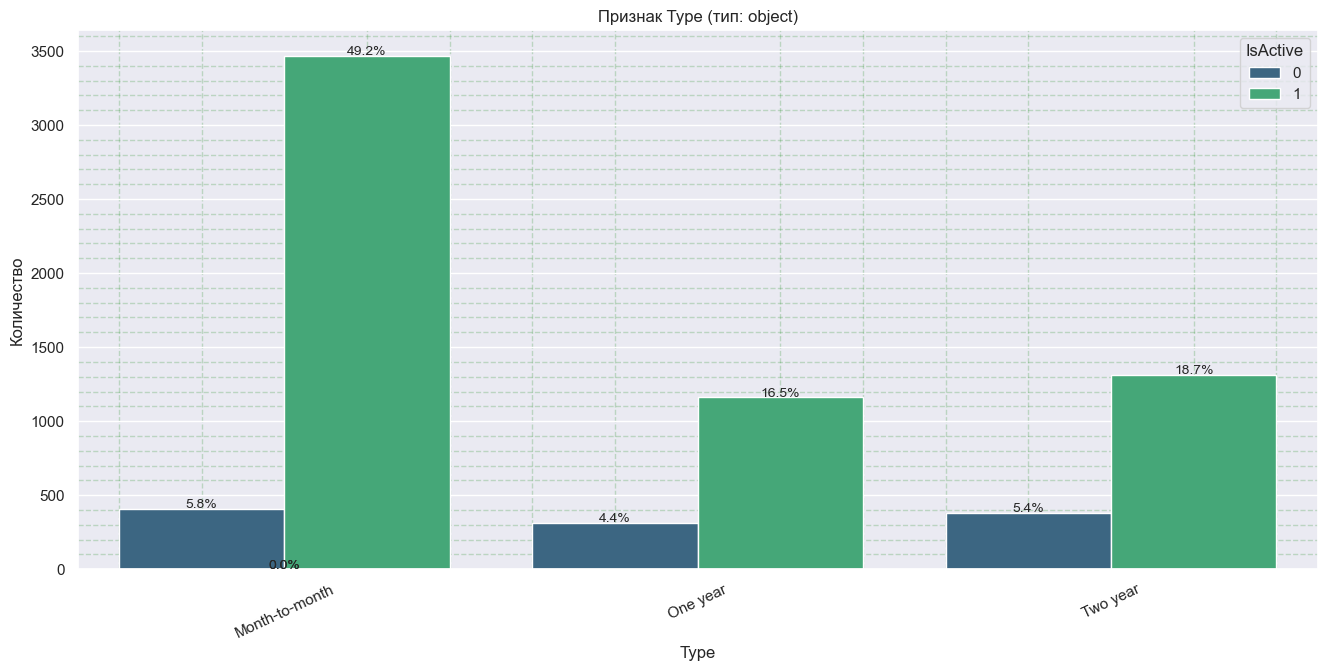

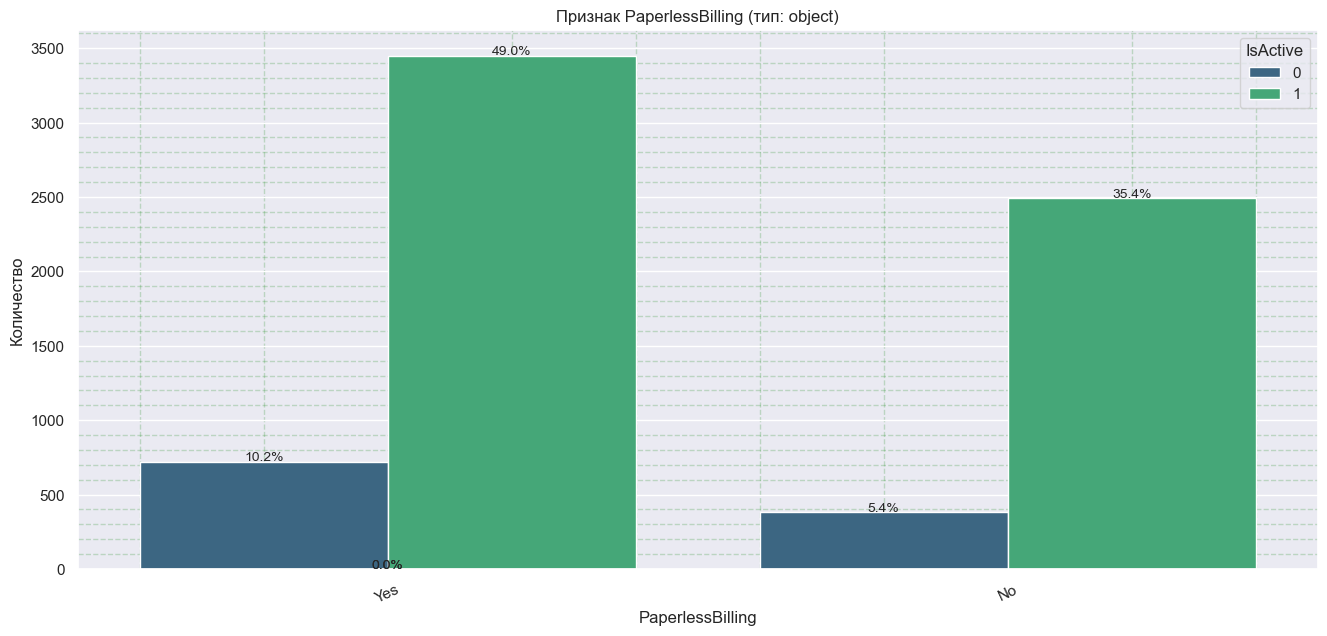

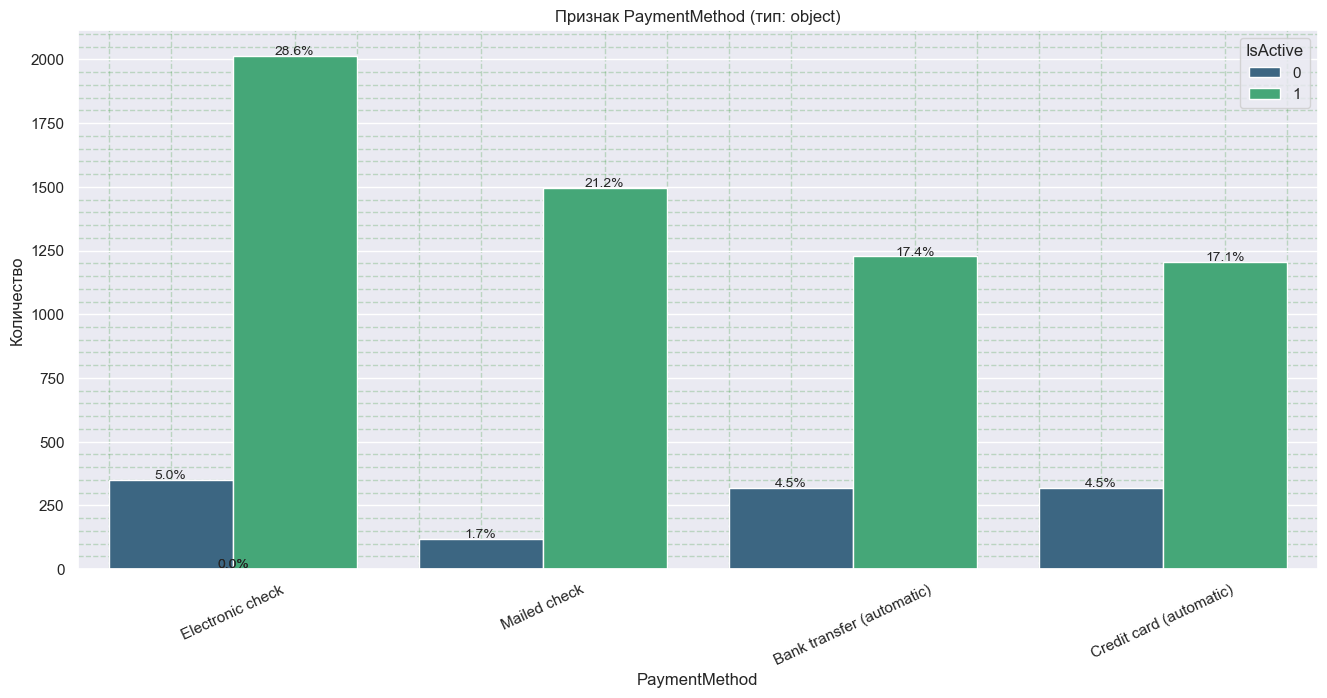

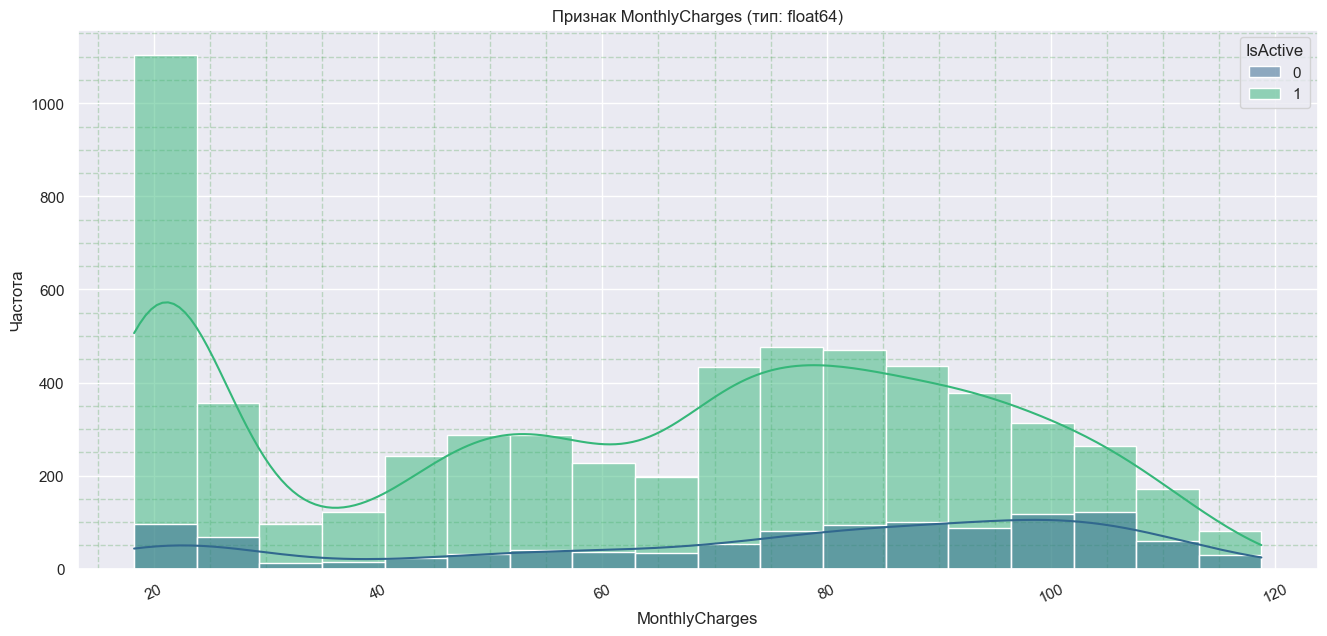

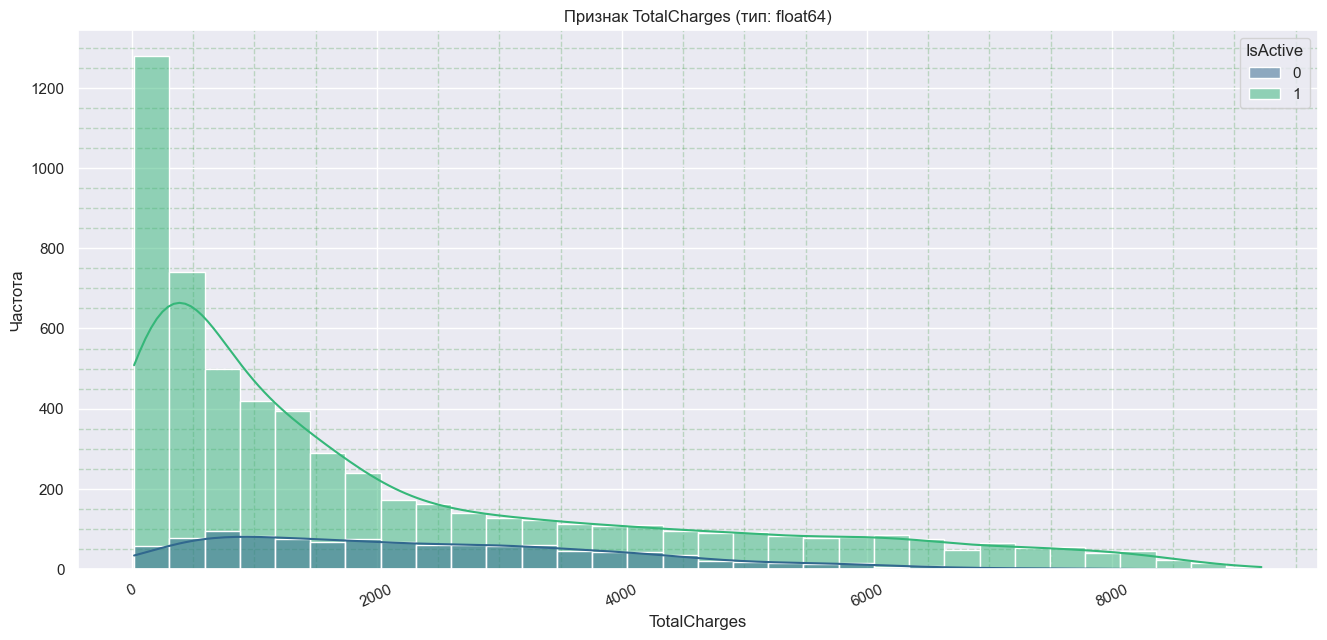

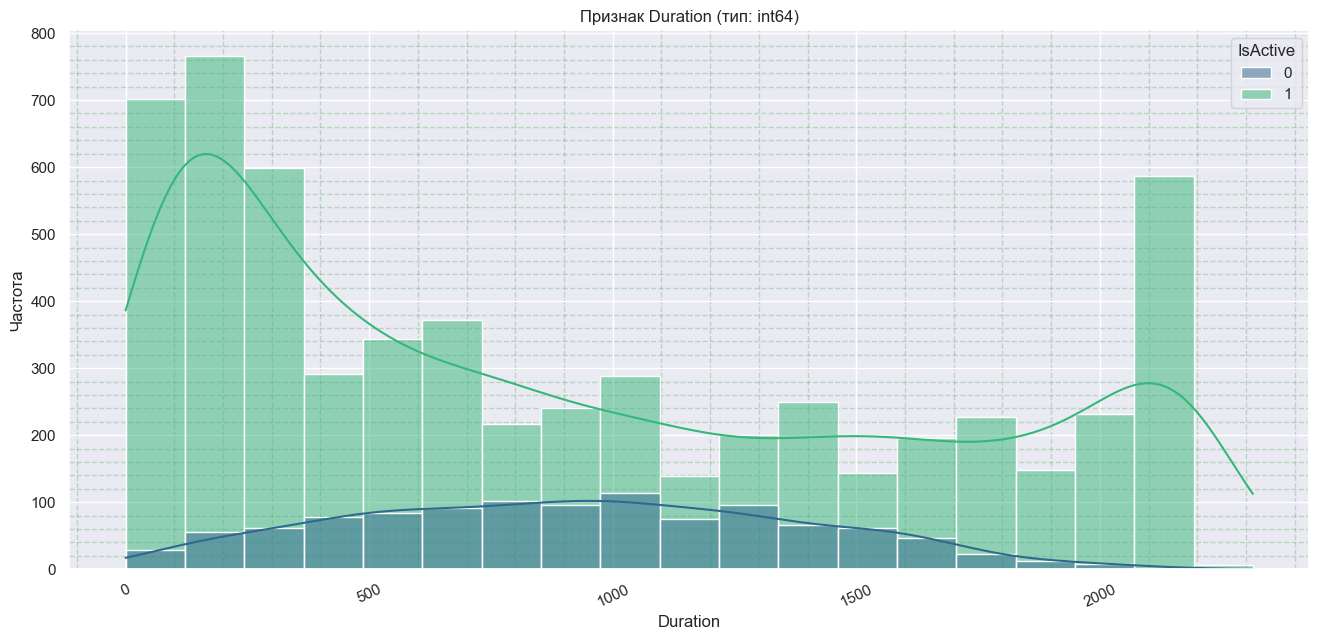

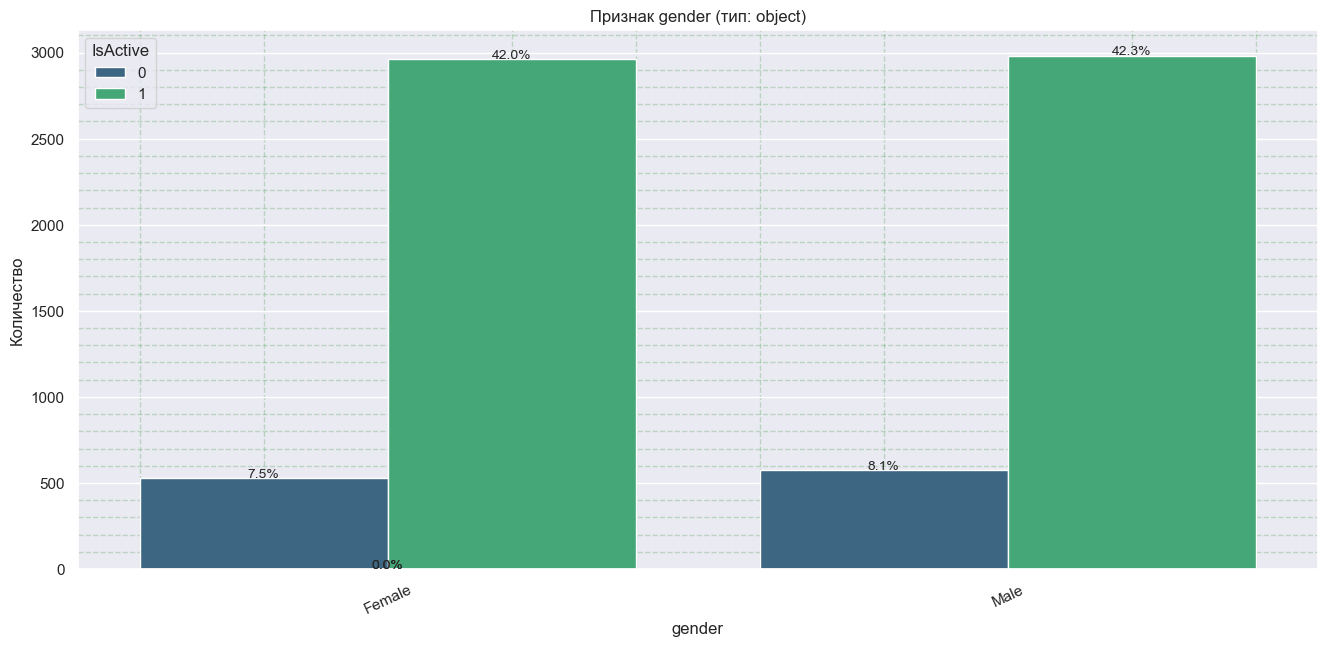

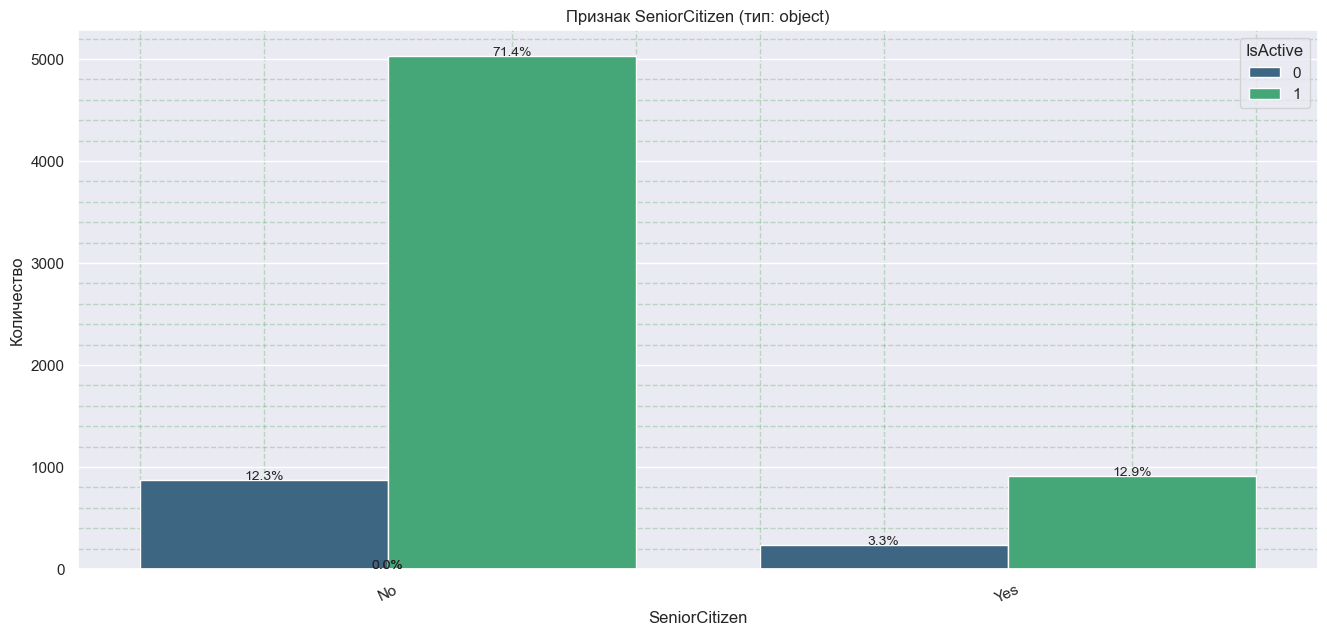

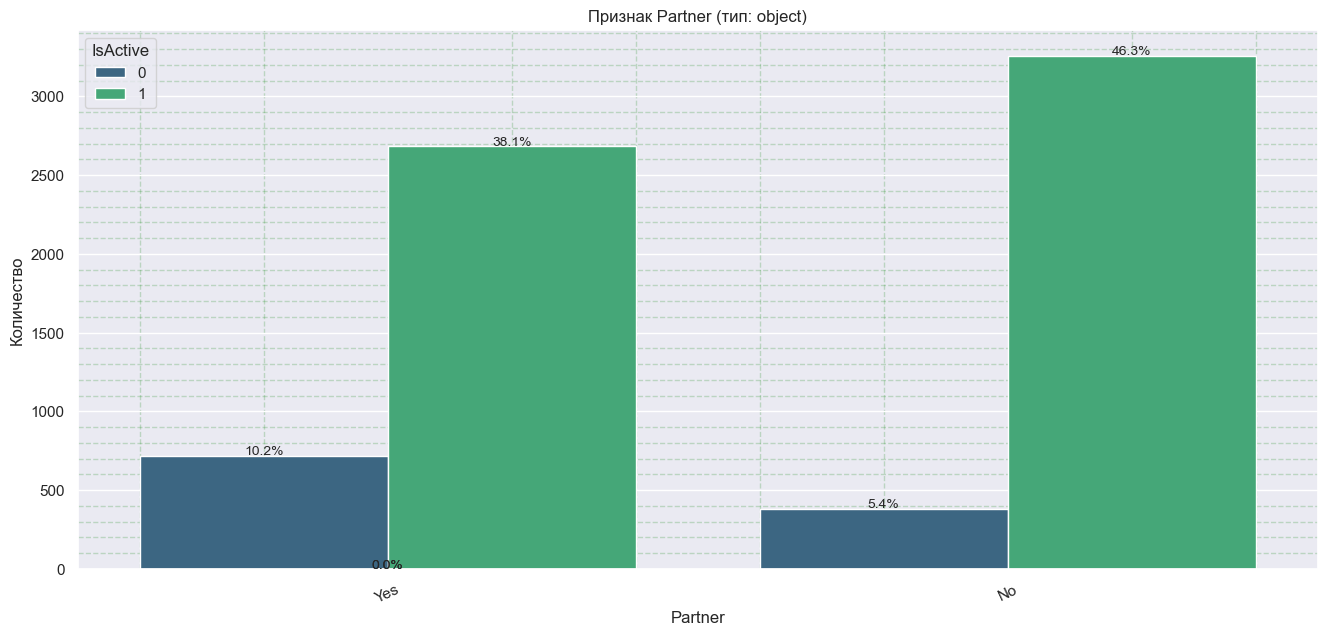

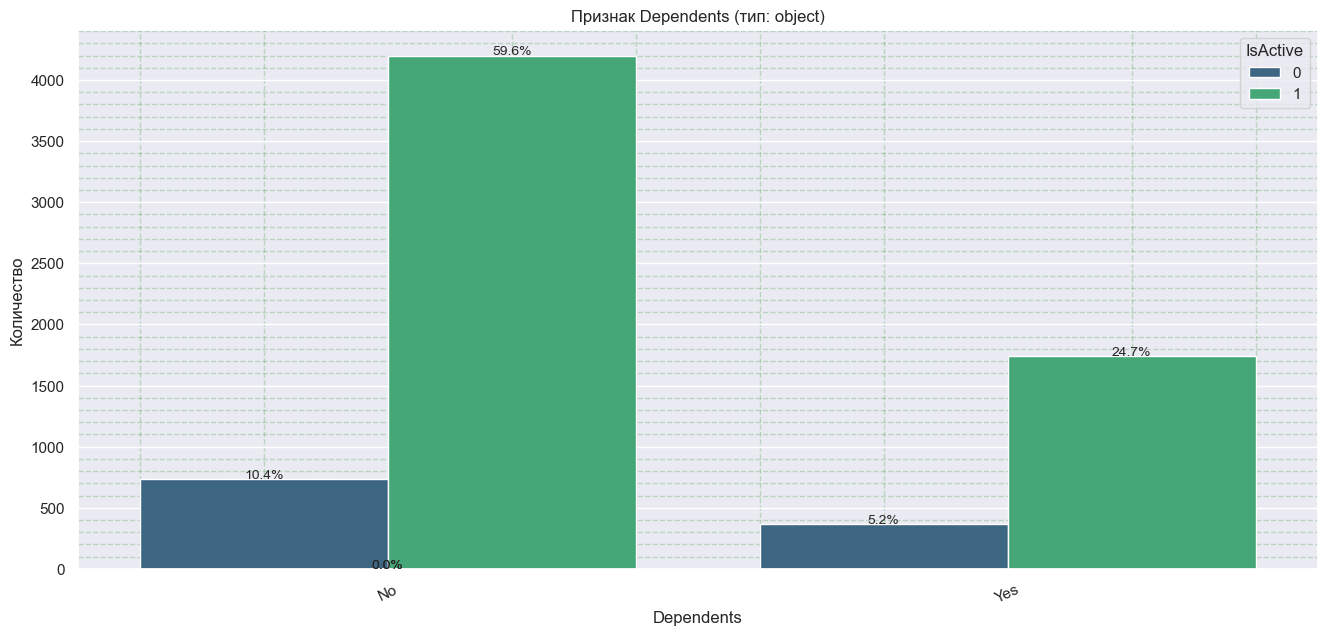

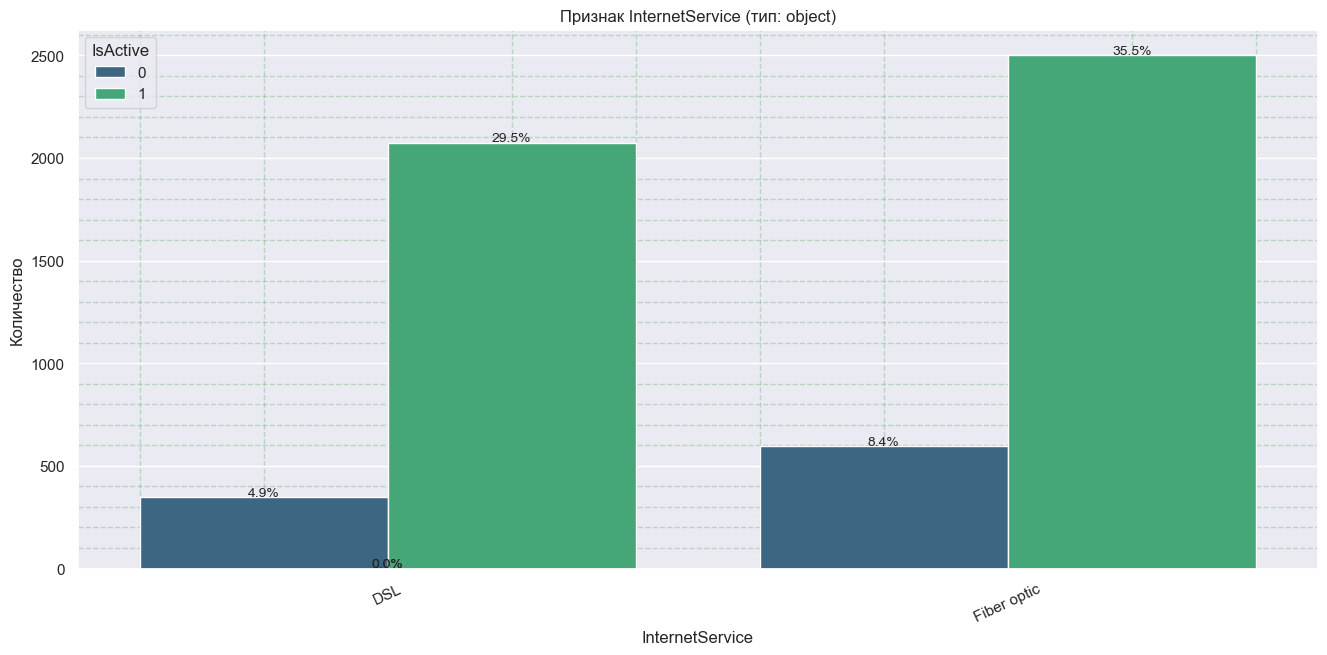

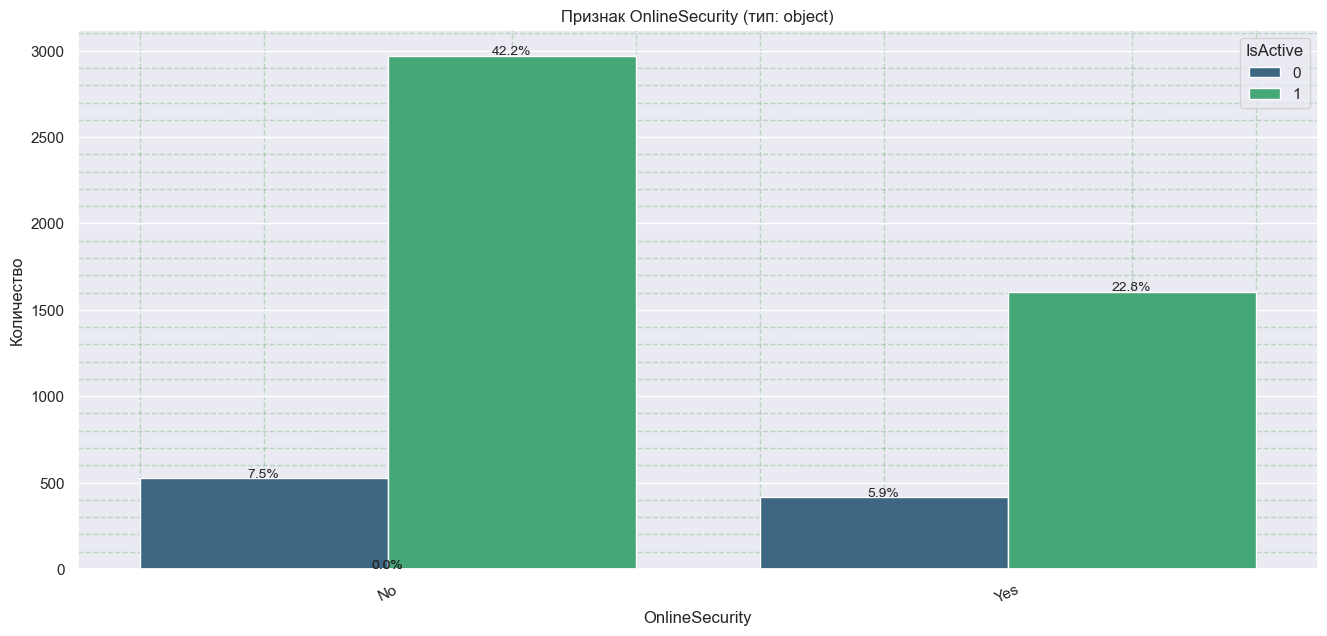

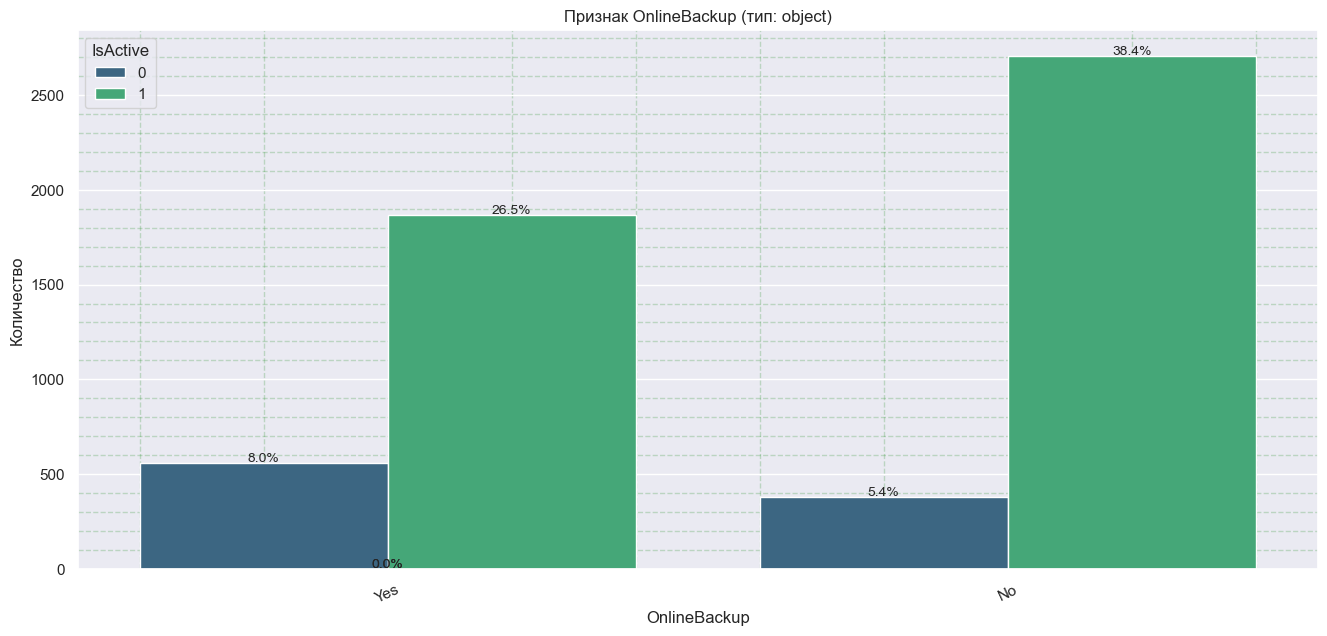

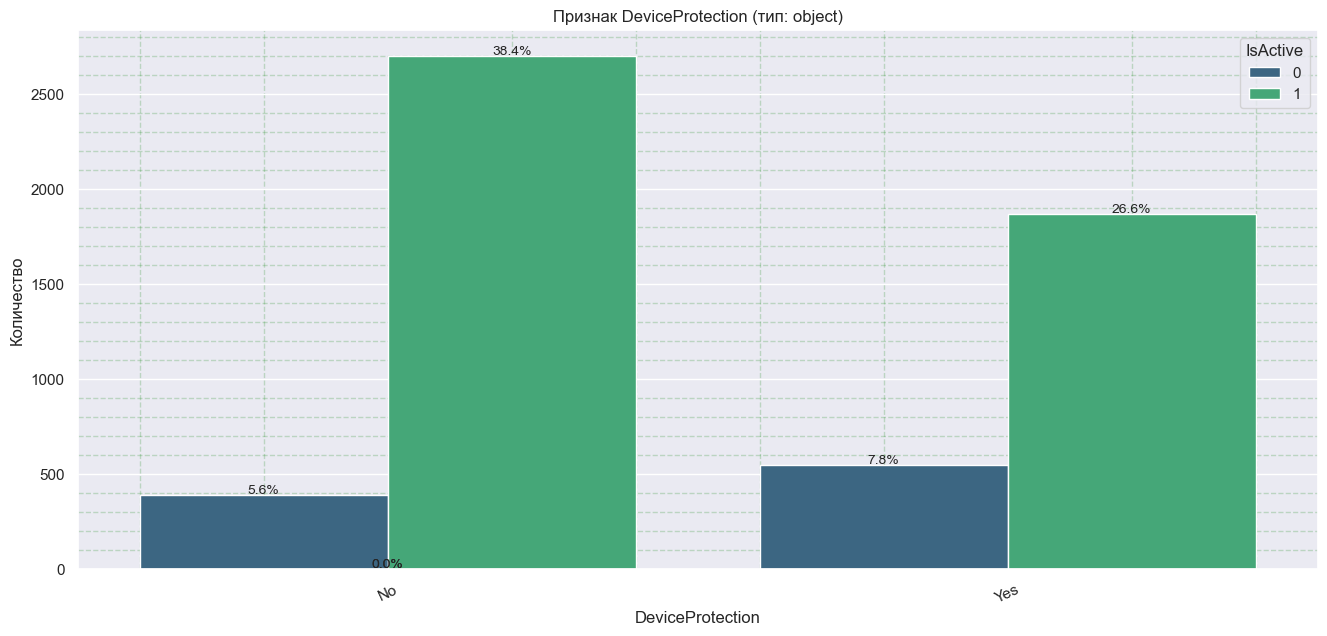

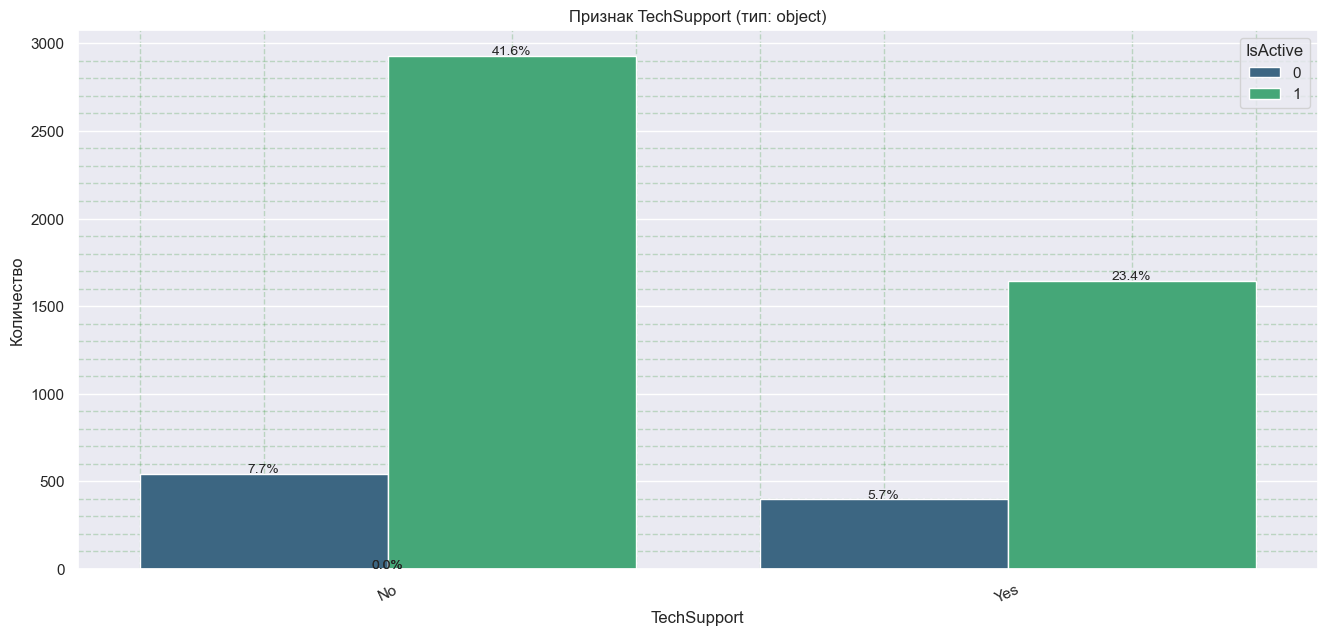

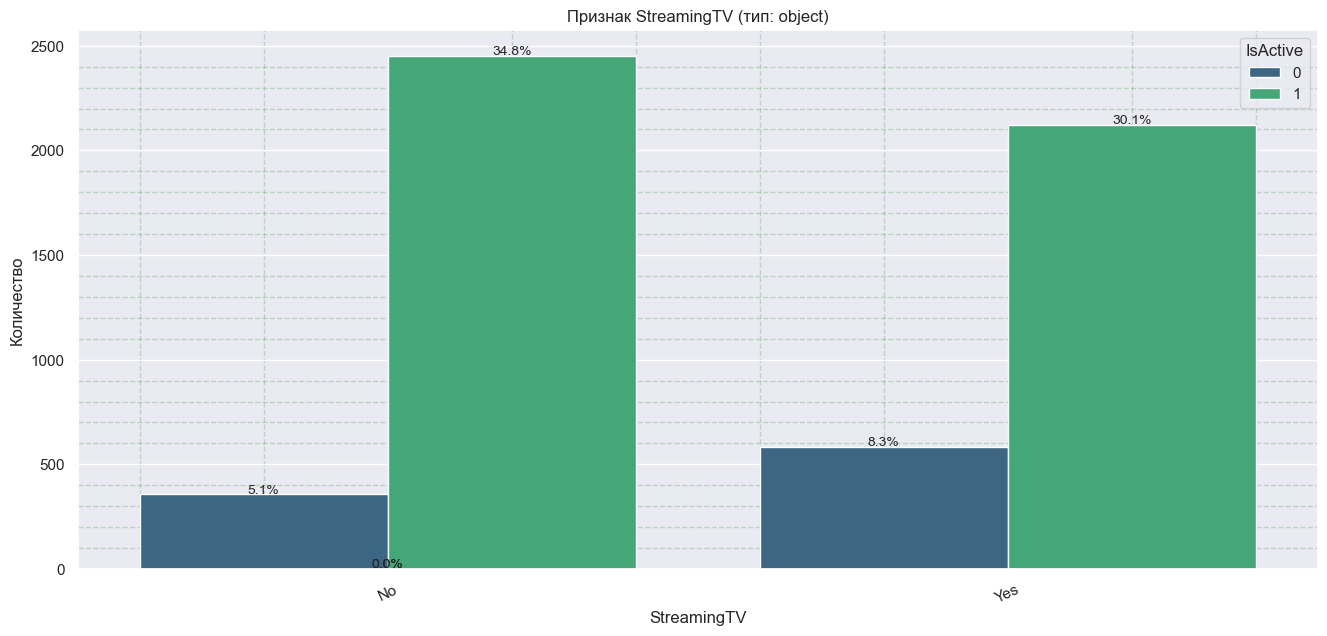

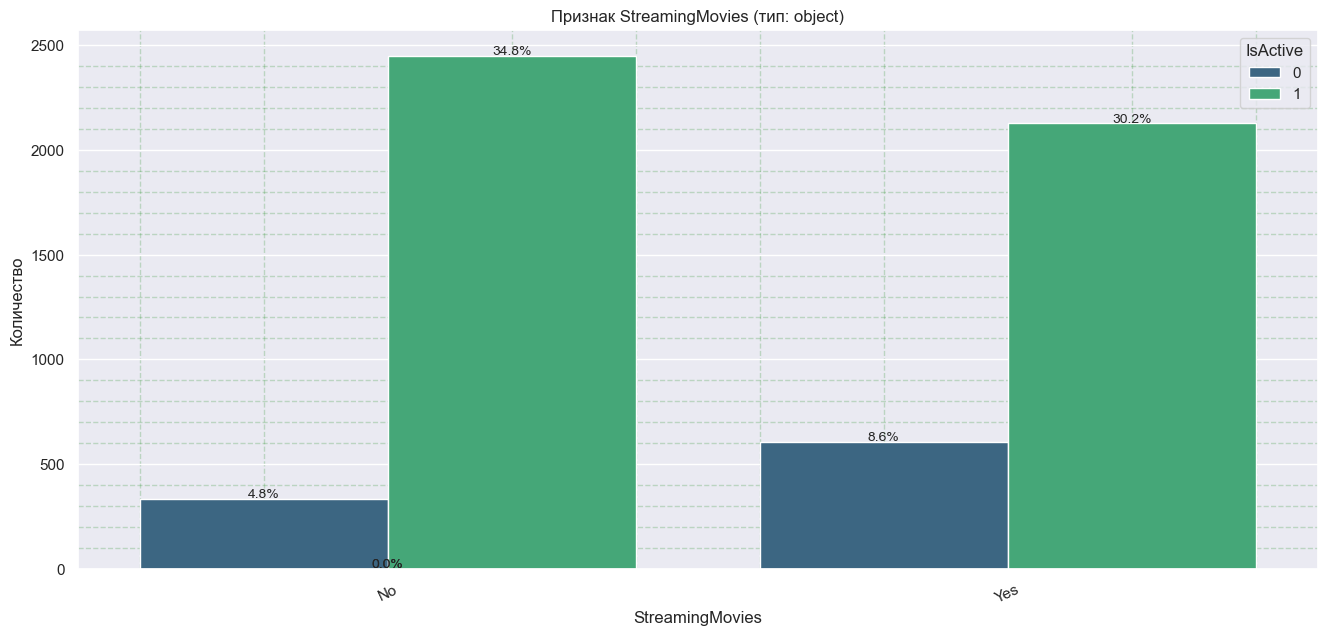

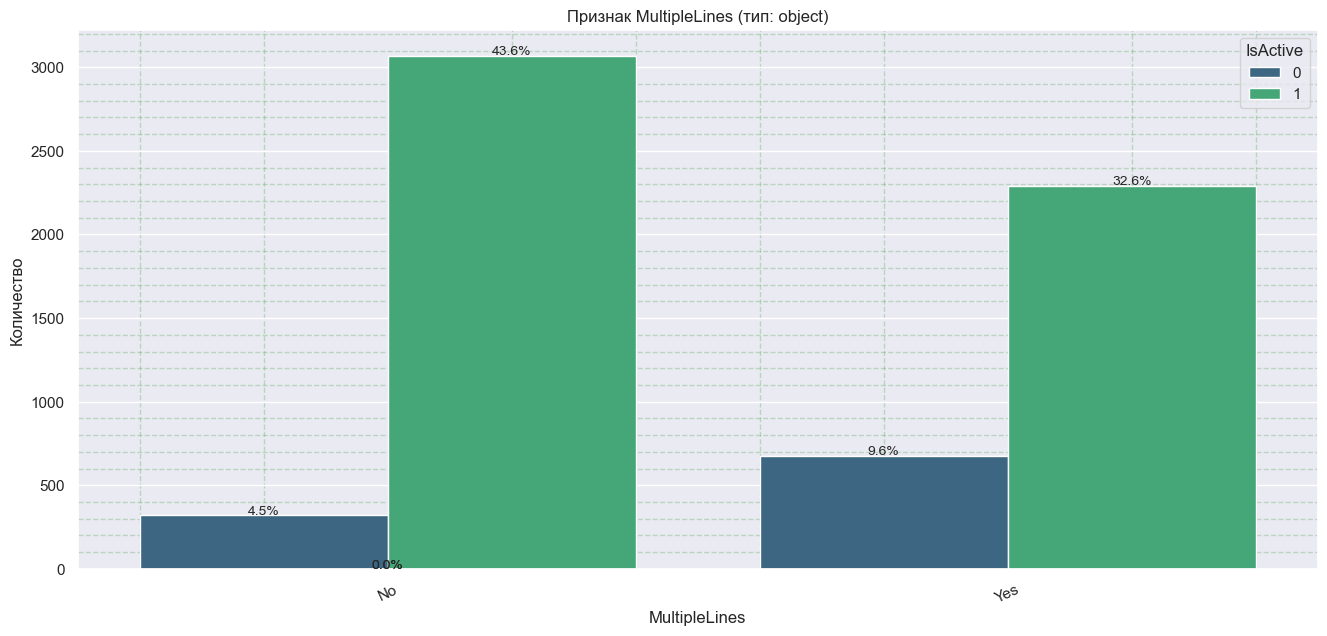

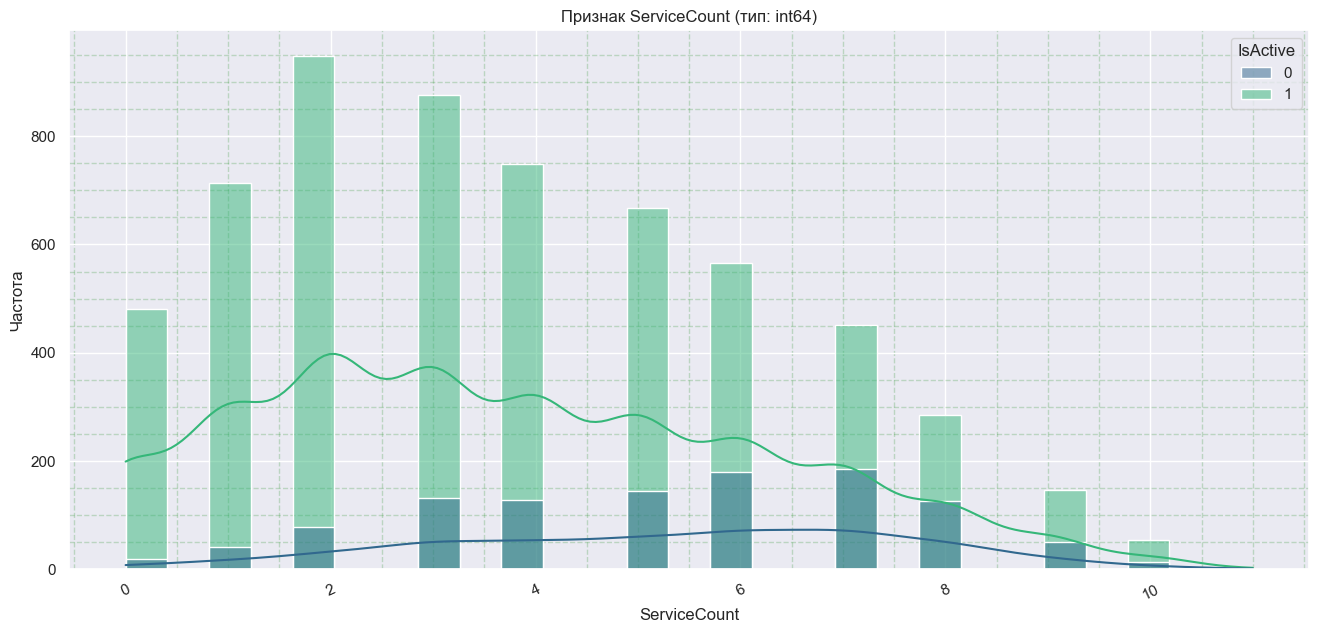

In [29]:
# Строим график
cat_plot(df_merged)

Мы видим, что большинство признаков влияют на отток клиентов и они информативны для дальнейшего обучения.

Но признаки `gender, StreamingTV, StreamingMovies`имеют равномерное распределение внутри целевого признака и поэтому ими можно пренебречь при обучении. 

Тоже самое можно сказать и о признаках `customerID, BeginDate, EndDate` - они неинформативны и могут создать утечку данных.

In [30]:
# Удалим признаки, которые не влияют на целевой
df_merged = df_merged.drop(['gender', 'StreamingTV',
                            'StreamingMovies', 'customerID',
                            'BeginDate', 'EndDate'], axis=1)
df_merged

Type PaperlessBilling              PaymentMethod  \
0     Month-to-month              Yes           Electronic check   
1           One year               No               Mailed check   
2     Month-to-month              Yes               Mailed check   
3           One year               No  Bank transfer (automatic)   
4     Month-to-month              Yes           Electronic check   
...              ...              ...                        ...   
7038        One year              Yes               Mailed check   
7039        One year              Yes    Credit card (automatic)   
7040  Month-to-month              Yes           Electronic check   
7041  Month-to-month              Yes               Mailed check   
7042        Two year              Yes  Bank transfer (automatic)   

      MonthlyCharges  TotalCharges  IsActive  Duration SeniorCitizen Partner  \
0              29.85         31.04         1        31            No     Yes   
1              56.95       2071.84         1      1036            No      No   
2              53.85        226.17         1       123            No      No   
3              42.30       1960.60         1      1371            No      No   
4              70.70        353.50         1       153            No      No   
...              ...           ...       ...       ...           ...     ...   
7038           84.80       2035.20         1       730            No     Yes   
7039          103.20       7430.40         1      2191            No     Yes   
7040           29.60        325.60         1       337            No     Yes   
7041           74.40        520.80         1       215           Yes     Yes   
7042          105.65       7251.82         1      2010            No      No   

     Dependents InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0            No             DSL             No          Yes               No   
1            No             DSL            Yes           No              Yes   
2            No             DSL            Yes          Yes               No   
3            No             DSL            Yes           No              Yes   
4            No     Fiber optic             No           No               No   
...         ...             ...            ...          ...              ...   
7038        Yes             DSL            Yes           No              Yes   
7039        Yes     Fiber optic             No          Yes              Yes   
7040        Yes             DSL            Yes           No               No   
7041         No     Fiber optic             No           No               No   
7042         No     Fiber optic            Yes           No              Yes   

     TechSupport MultipleLines  ServiceCount  
0             No           NaN             3  
1             No            No             2  
2             No            No             3  
3            Yes           NaN             3  
4             No            No             1  
...          ...           ...           ...  
7038         Yes           Yes             9  
7039          No           Yes             8  
7040          No           NaN             4  
7041          No           Yes             4  
7042         Yes            No             6  

[7043 rows x 17 columns]

### **Корреляционный анализ признаков** 

Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми признаками и построим тепловую карту.

In [31]:
# Вычисление матрицы корреляции
corr = df_merged.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'Duration', 'ServiceCount'])

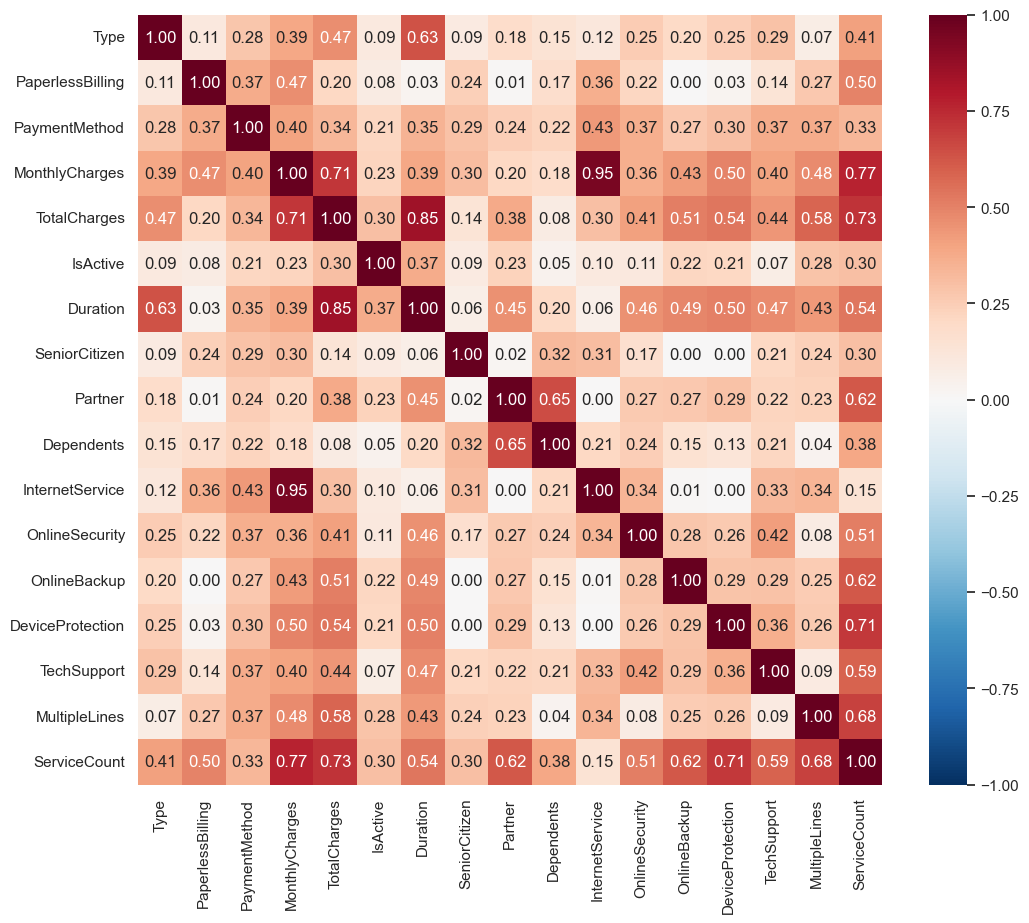

In [32]:
# Построение тепловой карты
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, vmin=-1, vmax=1);

Мы наблюдаем среднюю прямую связь между целевым и признаками `TotalCharges, Duration, ServiceCount`, а также слабую прямую связь между целевым и остальными. 


**Мультиколлинеарность** между входными признаками **наблюдается**. Коэффициент корреляции от 0.9 до 0.95 по модулю присутствует между признаками `MonthlyCharges` и `InternetService`. Удалим один из них.

In [33]:
# Удаляем признак InternetService
df_merged = df_merged.drop('InternetService', axis=1)
# Проверка
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   IsActive          7043 non-null   int64  
 6   Duration          7043 non-null   int64  
 7   SeniorCitizen     7043 non-null   object 
 8   Partner           7043 non-null   object 
 9   Dependents        7043 non-null   object 
 10  OnlineSecurity    5517 non-null   object 
 11  OnlineBackup      5517 non-null   object 
 12  DeviceProtection  5517 non-null   object 
 13  TechSupport       5517 non-null   object 
 14  MultipleLines     6361 non-null   object 
 15  ServiceCount      7043 non-null   int64  
dtypes: float64(2), int64(3), object(11)
memory

**Вывод:** таким образом, мы провели исследовательский и корреляционный анализ признаков в объединенном датасете и удалили неинформативные, мультиколлинеарные и не влияющие на обучение признаки.

## **Подготовка данных**
<a id='pipeline'></a>

Разобьем датасет на тренировочные и тестовые выборки.

In [34]:
# Разметим данные
X = df_merged.drop('IsActive', axis=1)
y = df_merged['IsActive']

In [35]:
# Разделим данные на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [36]:
# Посмотрим на разбиение
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5282, 15) (1761, 15) (5282,) (1761,)


Мы убедились в правильности выполнения разбиения, теперь подготовим данные, количественные и категориальные признаки обработаем в пайплайне.

In [37]:
# Создаём списки с названиями признаков
ohe_columns = ['Type', 'PaperlessBilling', 'PaymentMethod',
               'SeniorCitizen', 'Partner','Dependents',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'MultipleLines']
num_columns = ['MonthlyCharges', 'TotalCharges', 'Duration', 'ServiceCount']

# Кодируем категориальные значения
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
)

# Создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)


# Создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('feature_selection', SelectKBest(mutual_info_classif, k=4)),
        ('models', LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE, verbosity=-1))
    ]
)


**Вывод:** таким образом, мы подготовили данные для дальнейшего обучения на них моделей.

## **Обучение модели**
<a id='model'></a>

Напишем словарь для подбора лучших гиперпараметров.

In [38]:
param_grid = [
    # словарь для модели LGBMClassifier
    {
        'models': [LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE, verbosity=-1)],
        'models__n_estimators': [80, 100, 120],  
        'models__learning_rate': [0.15, 0.2, 0.25], 
        'models__max_depth': [4, 5, 6],  
        'models__num_leaves': [20, 30, 40],  
        'feature_selection__k': [2, 3, 4]  
    },
    
    # словарь для модели CatBoostClassifier
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)],
        'models__iterations': [80, 100],
        'models__learning_rate': [0.15, 0.2],  
        'models__max_depth': [5, 6, 7], 
        'models__l2_leaf_reg': [1, 3, 5]  
    },
    
    # DecisionTreeClassifier 
    {
        'models': [DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)],
        'models__max_depth': [3, 4, 5],  
        'models__min_samples_split': [20, 50, 100], 
        'feature_selection__k': [4, 6, 8] 
    }
]

Используем пайплайн и инструмент подбора гиперпараметров, чтобы выбрать лучшую модель. 

В качестве метрики возьмем ROC-AUC.

In [39]:
# Производим подбор гиперпараметров с помощью RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    verbose=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(fill_value='unknown',
                                                                                                              strategy='constant')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['Type',
                                                                                'PaperlessBilling',
                                                                                'PaymentMethod',
                                                                                'SeniorCitizen',
                                                                                'Partn...
                                         'models__iterations': [80, 100],
                                         'models__l2_leaf_reg': [1, 3, 5],
                                         'models__learning_rate': [0.15, 0.2],
                                         'models__max_depth': [5, 6, 7]},
                                        {'feature_selection__k': [4, 6, 8],
                                         'models': [DecisionTreeClassifier(class_weight='balanced',
                                                                           random_state=171125)],
                                         'models__max_depth': [3, 4, 5],
                                         'models__min_samples_split': [20, 50,
                                                                       100]}],
                   random_state=171125, scoring='roc_auc', verbose=10)

In [40]:
results_df = pd.DataFrame(randomized_search.cv_results_)[['rank_test_score',
                                                          'param_models',
                                                          'mean_test_score',
                                                          'params',
                                                          'mean_fit_time',
                                                          'mean_score_time']].sort_values('rank_test_score')

In [41]:
results_df

rank_test_score                                       param_models  \
13                1  LGBMClassifier(class_weight='balanced', random...   
0                 2  LGBMClassifier(class_weight='balanced', random...   
16                3  LGBMClassifier(class_weight='balanced', random...   
12                4  LGBMClassifier(class_weight='balanced', random...   
9                 5  LGBMClassifier(class_weight='balanced', random...   
11                6  LGBMClassifier(class_weight='balanced', random...   
1                 7  LGBMClassifier(class_weight='balanced', random...   
2                 8  LGBMClassifier(class_weight='balanced', random...   
17                9  LGBMClassifier(class_weight='balanced', random...   
7                10  LGBMClassifier(class_weight='balanced', random...   
19               11  LGBMClassifier(class_weight='balanced', random...   
3                12  LGBMClassifier(class_weight='balanced', random...   
14               13  LGBMClassifier(class_weight='balanced', random...   
10               14  LGBMClassifier(class_weight='balanced', random...   
5                15  LGBMClassifier(class_weight='balanced', random...   
4                16  DecisionTreeClassifier(class_weight='balanced'...   
6                17  <catboost.core.CatBoostClassifier object at 0x...   
8                17  <catboost.core.CatBoostClassifier object at 0x...   
18               17  <catboost.core.CatBoostClassifier object at 0x...   
15               17  <catboost.core.CatBoostClassifier object at 0x...   

    mean_test_score                                             params  \
13         0.878383  {'models__num_leaves': 40, 'models__n_estimato...   
0          0.875651  {'models__num_leaves': 20, 'models__n_estimato...   
16         0.874647  {'models__num_leaves': 30, 'models__n_estimato...   
12         0.870371  {'models__num_leaves': 30, 'models__n_estimato...   
9          0.869860  {'models__num_leaves': 20, 'models__n_estimato...   
11         0.869728  {'models__num_leaves': 20, 'models__n_estimato...   
1          0.869722  {'models__num_leaves': 20, 'models__n_estimato...   
2          0.869026  {'models__num_leaves': 40, 'models__n_estimato...   
17         0.868681  {'models__num_leaves': 20, 'models__n_estimato...   
7          0.868396  {'models__num_leaves': 20, 'models__n_estimato...   
19         0.866190  {'models__num_leaves': 40, 'models__n_estimato...   
3          0.865733  {'models__num_leaves': 20, 'models__n_estimato...   
14         0.862606  {'models__num_leaves': 30, 'models__n_estimato...   
10         0.858248  {'models__num_leaves': 40, 'models__n_estimato...   
5          0.857708  {'models__num_leaves': 30, 'models__n_estimato...   
4          0.783643  {'models__min_samples_split': 50, 'models__max...   
6               NaN  {'models__max_depth': 7, 'models__learning_rat...   
8               NaN  {'models__max_depth': 6, 'models__learning_rat...   
18              NaN  {'models__max_depth': 5, 'models__learning_rat...   
15              NaN  {'models__max_depth': 6, 'models__learning_rat...   

    mean_fit_time  mean_score_time  
13       1.520171         0.025577  
0        1.354980         0.028617  
16       1.468880         0.026293  
12       1.279568         0.026340  
9        1.172153         0.028178  
11       1.568219         0.027685  
1        1.428596         0.031406  
2        1.517849         0.026446  
17       1.077396         0.025468  
7        1.260650         0.024878  
19       0.708217         0.023075  
3        1.150430         0.025664  
14       1.082522         0.025169  
10       1.405268         0.025669  
5        1.067166         0.024350  
4        0.649690         0.020141  
6        0.993678         0.003238  
8        0.886370         0.002475  
18       0.819852         0.001586  
15       0.850126         0.001990

Мы видим, что модель, которую мы получили при подборе гиперпараметров выигрывает не только по качеству, но и по времени обучения. Остановим свой выбор на ней.

In [42]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_[0],'\n',
      randomized_search.best_estimator_[1], '\n',randomized_search.best_estimator_[2], '\n')
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Type', 'PaperlessBilling', 'PaymentMethod',
                                  'SeniorCitizen', 'Partner', 'Dependents',
                                  'OnlineSecurity', 'OnlineBackup',
                                  'DeviceProtection', 'TechSupport',
                                  'MultipleLines']),
                                ('num', MinMaxScaler(),
            

**Вывод:** лучшая модель имеет следующие параметры: 

**LGBMClassifier**(class_weight='balanced', learning_rate=0.25, max_depth=5,
               n_estimators=80, num_leaves=20, random_state=171125,
               verbosity=-1),

метрика ROC-AUC на на кросс-валидации составляет 0.88 - результат успешный.


## Тестирование лучшей модели
<a id='test'></a>

Проверим качество выбранной модели на тестовой выборке.

In [43]:
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba)}')
print(f'Точность на тестовой выборке: {accuracy_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.9148142809624126
Точность на тестовой выборке: 0.8620102214650767


**ROC-AUC = 0.91** - модель очень хорошо разделяет классы.

**Точность = 0.86** - можно доверять положительным прогнозам модели.

Метрика удовлетворяет требованиям заказчика.

### Анализ важности признаков

Посмотрим, какие признаки лучше всего повлияли на результат модели.

In [44]:
# Извлекаем названия и коэффициенты признаков
best_pipe = randomized_search.best_estimator_

selected_features = best_pipe.named_steps['feature_selection'].get_feature_names_out()
importances = best_pipe.named_steps['models'].feature_importances_
all_features = best_pipe.named_steps['preprocessor'].get_feature_names_out()

real_names = [all_features[int(i[1:])] for i in selected_features]

# Создаем итоговый датафрейм
feature_importance = pd.DataFrame({
    'feature': real_names,
    'importance': importances
}).sort_values('importance', ascending=False)

feature_importance.head()

feature  importance
1      num__Duration        1176
0  num__TotalCharges         799
2  num__ServiceCount         369

Длительность договора, общие расходы и количество используемых услуг - самые важные факторы для прогнозирования. Лояльность клиентов связана с долгосрочностью контрактов и объемов услуг.

### ROC-кривая

Посмотрим на ROC-кривую.

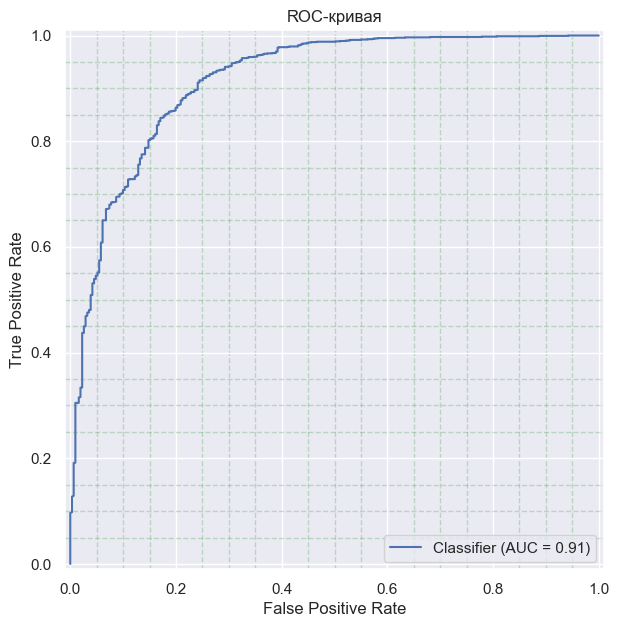

In [45]:
plt.figure(figsize=(7, 7))
ax = plt.gca()

RocCurveDisplay.from_predictions(
    y_test, 
    y_test_proba,
    ax=ax
)

plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
plt.minorticks_on()
plt.tick_params(which='minor')
plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Кривая сильно приближена к левому верхнему углу, значительно выше диагонали по всей длине. Это говорит о том, что модель отличного качества.

Быстрый подъем в начале - модель хорошо обнаруживает положительные классы

### Матрица ошибок

Построим матрицу ошибок.

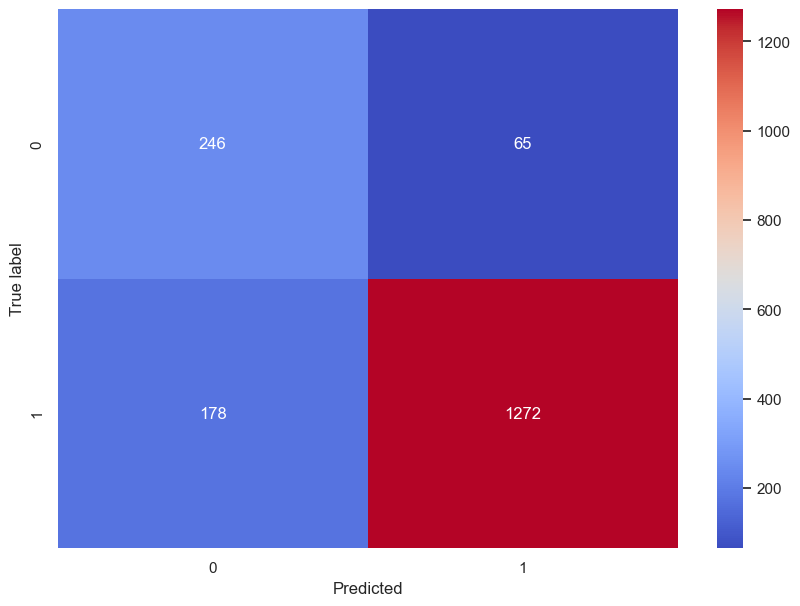

In [46]:
# Считаем матрицу
cm = confusion_matrix(y_test, y_test_pred)
# Визуализируем через тепловую карту
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.ylabel('True label')
plt.xlabel('Predicted');

В **178** случаях модель предсказывает положительный класс как отрицательный и в **65** случаях модель дает ложно-положительный ответ.

Но модель очень хорошо справляется с правильным разделением на ушедших и оставшихся клиентов - **1272** правильных положительных и **246** - правильных отрицательных.

В итоге мы получили модель с высоким recall (88%) и хорошей precision (95%), что говорит нам о отличном обнаружении и высокой надежности прогнозов.

**Вывод:** таким образом, мы проанализировали важность признаков, ROC-кривую и матрицу ошибок, и удостоверились в выборе лучшей модели, которая удовлетворяет требованиям заказчика.

## **Итоговые выводы**
<a id='final'></a>

Таким образом мы создали модель, которая будет предсказывать, разорвёт ли абонент договор для компании «ТелеДом»:

1. Построили модель для прогноза оттока клиентов.

Для этого были выполнены следующие действия:

- **Открыты файлы** с данными и изучена общая информация: 

    Датафрейм `contract_new.csv` содержал **7043 строк и 8 столбцов**. В данных пропуски отсутствовали, типы данных некорректны.

    Датафрейм `personal_new.csv` содержал **7043 строк и 5 столбцов**. В данных пропуски отсутствовали, типы данных корректны.

    Датафрейм `internet_new.csv` содержал **5517 строк и 8 столбцов**. В данных пропуски отсутствовали, типы данных корректны.

    Датафрейм `phone_new.csv` содержал **6361 строку и 2 столбца**. В данных пропуски отсутствовали, типы данных корректны.

- Выполнена **предобработка данных:**
    
    обработали явные и неявные дубликаты;
    преобразовали типы данных;
    добавили новые столбцы.

- Провели **исследовательский анализ данных:**

  проверили аномальные значения и посмотрели на распределение количественных и категориальных признаков каждого датафрейма
  

- Объединили данные:
    
    в результате в объединенном датасете оказались пропуски, что связано с клиентами, которые могут пользоваться не всеми услугами компании. А также на основе полученного датафрейма  создали новый признак - количество используемых услуг клиента.
    
- Провели **исследовательский и корреляционный анализ объединенного датасета**:

    в объединенном датасете и удалили неинформативные, мультиколлинеарные и не влияющие на обучение признаки.
    
- Применили пайплайны для подготовки признаков и обучения модели:

    перебирали гиперпараметры для моделей дерева решений и градиентного бустинга

- Выбрали лучшую модель, проанализировали важность признаков, матрицу ошибок и ROC-кривую:

    **LGBMClassifier(class_weight='balanced', learning_rate=0.25, max_depth=5, n_estimators=80, num_leaves=20, random_state=171125, verbosity=-1)**.
    **ROC-AUC = 0.91** - модель очень хорошо разделяет классы.
    **Точность = 0.86** - можно доверять положительным прогнозам модели.
    Метрика удовлетворяет требованиям заказчика - больше 0.85.
    
**Рекомендации для бизнеса:** 

Обратить внимание на пользователей с долгосрочным договором, количеством используемых услуг и общими расходами - эти факторы больше всего влияют на отток клиентов.



In [62]:
# Генерация файла requirements.txt с актуальными версиями библиотек

# Список библиотек, которые используются в проекте
packages = [
    'pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 
    'lightgbm', 'catboost', 'scipy', 'phik','ipykernel'
]

# Получаем установленные версии
requirements = []
for package in packages:
    try:
        version = importlib.metadata.version(package)
        requirements.append(f"{package}=={version}")
    except :
        print(f"Библиотека {package} не найдена в окружении. Возможно, она не установлена.")

# Сохранить в файл requirements.txt
with open("requirements.txt", "w") as f:
    f.write("# Требования для проекта\n")
    f.write("\n".join(requirements))


Библиотека os не найдена в окружении. Возможно, она не установлена.
🎯 Сформированные зависимости:

pandas==2.2.3
numpy==1.26.4
matplotlib==3.10.0
seaborn==0.13.2
scikit-learn==1.8.0
lightgbm==4.6.0
catboost==1.2.8
scipy==1.15.1
phik==0.12.5
ipykernel==6.29.5

✅ Файл requirements.txt успешно сохранён в папку: /Users/ajmailova/Documents/ЯндексПрактикум_DataScience/Yandex-practicum-projects/project14_final


In [60]:
packages = [
    'pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 
    'lightgbm', 'catboost', 'scipy', 'phik', 'ipykernel', 'os'
]

# Получаем установленные версии
requirements = []
for package in packages:
    package.__version__

AttributeError: 'str' object has no attribute '__version__'